In [203]:
################## DEFINIZIONI FUNZIONI E VARIABILI UTILI ###################
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
from scipy.optimize import curve_fit
import os
import re
from os.path import exists, isfile, join
import subprocess
import time
import urllib.request
import urllib.parse
import json
import logging
import multiprocessing
from numpy import linspace, round as around
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import sympy as sp
import sys
import random

####
path_to_pythonEnv = f"/home/starcat/Scrivania/ANALISIATM/.venv/bin/python"
path_to_linemake = f"/home/starcat/LINEE"
path_to_ARES = f"/home/starcat/Modelli/ARES-master"
path_to_abundance = f"/home/starcat/Scrivania/ANALISIATM/spectrum277c/"
path_to_abundance_0 = f"/home/starcat/Scrivania/ANALISIATM/spectrum277c_0/"
path_to_abundance_1 = f"/home/starcat/Scrivania/ANALISIATM/spectrum277c_1/"
path_to_abundance_2 = f"/home/starcat/Scrivania/ANALISIATM/spectrum277c_2/"
path_to_mainfolder = f"/home/starcat/Scrivania/ANALISIATM/"
path_to_atmosphere = f"/home/starcat/Scrivania/ANALISIATM/ATMOSFERE/"
path_to_rnd = f"/home/starcat/Scrivania/ANALISIATM/rnd"
path_to_output = f"/home/starcat/Scrivania/ANALISIATM/ABBONDANZE_OUT/"
path_to_interpol = f"/home/starcat/Scrivania/ANALISIATM/interpol/PyKMOD-main/"
path_to_correctionGrids = f"/home/starcat/Scrivania/ANALISIATM/correctionGrids/"
path_to_correctionGrids1 = f"/home/starcat/Scrivania/ANALISIATM/iron_abundancecorr/correctionGrids/"
path_to_nlteInterpol = f"/home/starcat/Scrivania/ANALISIATM/1L-3NErrors-main/"
path_to_calibrationFolder = f"/home/starcat/Scrivania/ANALISIATM/Calibrazione"
path_to_fitsFiles = f"/home/starcat/Documenti/Reduced_AOT41/Reduced_AOT41" #path_to_ARES
####


NEW_MATRIX = np.array([[-2.73752381e-04,  2.22800000e-03,  1.25531429e-03,  3.30684003e-03],
            [-3.53622447e-02, -4.34489796e-01, -1.34193878e-01, -6.97848163e+00],
            [-1.50857143e-02, -4.02285714e-01, -1.15394286e+00, -2.93710716e+00],
            [-4.89264069e-03, -2.08303030e-01, -4.36747186e-01, -2.23545660e+01]])
MATRIX = NEW_MATRIX.T
#crea_MatriceRicerca(T, G, M, v): #il fatto che alcune grandezze richiedano un fit quadratico implica una dipendenza dalle grandezze stesse.

N_stelle = 14
trials = 30
temp_log = np.zeros(trials)
logg_log = np.zeros(trials)
T_slope = np.zeros((trials, 2))
Logg_slope = np.zeros((trials, 2))
temp_best_guess1 = 0
temp_best_guess2 = 0
temp_best_guess3 = 0
temperatura = [3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000]
logg_arr = [0, 0.50000, 1.00000, 1.50000, 2.00000, 2.50000, 3.00000, 3.50000, 4.00000, 4.50000, 5.00000]
MH = ["05", "02", "00", "-05", "-10", "-15", "-20"]
metallicity = ["0.5", "0.2", "0.0", "-0.5", "-1.0", "-1.5", "-2.0", "-2.5"]
metallic = [0.5, 0.2, 0.0, -0.5, -1.0, -1.5, -2.0, -2.5]
metallic_header = [-2.5, 2.0, -1.5, -1.0, -0.5, 0.0, 0.2, 0.5]
T_EFF_int = np.arange(3500, 5500 + 1, 25)
LOGG_int = np.arange(0.5, 5 + 0.06, 0.05)
MH_int = np.arange(0.0, -2.5 - 0.06, -0.05)
T_EFF_Nint = np.arange(3500, 6000 , 250)
LOGG_Nint = np.arange(0.5, 5 + 0.06, 0.5)
MH_Nint = np.arange(0.0, -2.5 - 0.06, -0.5)
MICROTURB = [0.75, 1.5, 3.0]
ABUNDANCE_SCALE = [3.16228, 1.58489, 1.00000, 0.31620, 0.10000, 0.03162, 0.01000, 0.00316]
ABUNDANCE_SCALE_header = [0.00316, 0.01000, 0.03162, 0.10000, 0.31620, 1.00000, 1.58489, 3.16228]
lineList = "Iron_lines"
minceData = [["HARPN1", 4746, 1.89, -0.56],
             ["HARPN2", 4610, 1.73, -0.58],
             ["HARPN3", 4458, 1.54, -0.56],
             ["HARPN4", 4045, 1.21, -0.64],
             ["HARPN5", 4444, 4,-0.5],
             ["HARPN6", 4722, 1.89, 0.02],
             ["HARPN7", 4725, 2.41, -0.19],
             ["HARPN8", 4444, 4, -0.5],
             ["HARPN9", 4458, 1.54, -0.56],
             ["HARPN10", 4393, 1.08, -1.99],
             ["HARPN11", 4193, 0.71, -1.95],
             ["HARPN12", 4167, 0.82, -1.45],
             ["HARPN13", 4154, 0.52, -2.09],
             ["HARPN14", 4287, 0.70, -1.71],
             ["HARPN15", 4316, 0.87, -1.46],
             ["HARPN16", 4276, 0.70, -2.27],
             ["HARPN17", 4249, 0.79, -1.61]]
NLTE_wavelenght = [3440.610, 
                   436.886,
            3440.990,
            3465.860,
            3475.440,
            3490.570,
            3565.380,
            3570.100,
            3581.190,
            3608.860,
            3618.770,
            3719.920,
            3737.120,
            3727.620,
            3745.560,
            3748.260,
            3758.230,
            3763.790,
            3815.840,
            3820.430,
            3824.440,
            3825.870,
            3840.440,
            3856.370,
            3859.910,
            3922.910,
            4045.810,
            4063.590,
            4071.740,
            4235.940,
            4250.120,
            4250.790,
            4415.120,
            4445.470,
            4494.560,
            4920.500,
            4994.130,
            5044.210,
            5198.700,
            5216.270,
            5225.520,
            5232.940,
            5236.200,
            5242.490,
            5247.040,
            5250.210,
            5269.540,
            5281.790,
            5379.570,
            5383.370,
            5434.521,
            5491.830,
            5586.750,
            5600.220,
            5661.350,
            5662.520,
            5696.090,
            5701.540,
            5705.460,
            5778.450,
            5784.660,
            5855.080,
            5916.250,
            5956.690,
            6065.479,
            6082.710,
            6151.620,
            6173.330,
            6200.310,
            6219.280,
            6240.650,
            6252.560,
            6265.130,
            6297.790,
            6311.500,
            6430.850,
            6498.940,
            6518.370,
            6574.229,
            6593.870,
            6609.110,
            6699.140,
            6726.670,
            6739.521,
            6750.150,
            6793.260,
            6810.260,
            6837.010,
            6854.820,
            6945.200,
            6978.850,
            7401.680,
            7912.870,
            8293.500,
            4233.170,
            4491.390,
            4508.290,
            4576.330,
            4582.840,
            4583.830,
            4620.520,
            4923.930,
            5018.440,
            5169.020,
            5197.580,
            5234.620,
            5264.810,
            5284.110,
            5325.550,
            5414.070,
            5425.260,
            6239.950,
            6247.560,
            6369.460,
            6432.680,
            6456.380,
            6516.080,
            7222.390,
            7224.490,
            7515.830,
            7711.720]

class Star:
    def __init__(self, name, T, G, M, v):
        self.name = name
        self.T = int(T)
        self.G = float(G)
        self.M = float(M)
        self.v = float(v)
def def_s_Matrix():
    vv=sp.symbols('v')
    dsdv1=-0.015639
    dFdv1=0.1194805
    dYdv1=0.2560606
    dSdv1=1.7464315
    dsdv2=0.0242265
    dFdv2=-0.445342
    dYdv2=-0.939681
    dSdv2=-26.17745
    dsdt=-0.000273752
    dFdt=0.002228
    dYdt=0.001255
    dSdt=0.003307
    dsdg=-0.035362
    dFdg=-0.434498
    dYdg=-0.134194
    dSdg=-6.978472
    dsdm=-0.015086
    dFdm=-0.402286
    dYdm=-1.153942
    dSdm=-2.937107
    s_Matrix=sp.Matrix([[dsdt, dsdg, dsdm, dsdv1*vv+dsdv2],
                        [dFdt, dFdg, dFdm, dFdv1*vv+dFdv2],
                        [dYdt, dYdg, dYdm, dYdv1*vv+dYdv2],
                        [dSdt, dSdg, dSdm, dSdv1*vv+dSdv2]])
    return s_Matrix
s_Matrix=def_s_Matrix()
# Funzione per bloccare le stampe a schermo
def blocca_stampe():
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

# Funzione per riattivare le stampe a schermo
def nome_da_Fits(path_to_fits=path_to_fitsFiles, nome='HARPN1.fits'):
    # Apri il file FITS
    hdul = fits.open(path_to_fits+"/"+nome)

    # Stampa informazioni sul file
    #hdul.info()

    # Accedi all'header della prima estensione
    header = hdul[0].header

    # Stampa l'header completo (opzionale)
    #print(repr(header))

    # Se sai il nome della keyword che contiene il nome della stella, puoi accedere direttamente
    # Ad esempio, supponiamo che il nome della stella sia memorizzato sotto la keyword 'OBJECT'
    nome_stella = header.get('HIERARCH TNG OBS TARG NAME', 'Nome della stella non trovato')

    print(f'Nome della stella: {nome_stella}')

    # Chiudi il file FITS
    hdul.close()
    return nome_stella
def riattiva_stampe():
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
def crea_cartella(percorso):
    try:
        # Controlla se la cartella esiste già
        if not os.path.exists(percorso):
            os.makedirs(percorso)  # Crea la cartella
            print(f"Cartella '{percorso}' creata con successo!")
        else:
            print(f"La cartella '{percorso}' esiste già.")
    except Exception as e:
        print(f"Errore durante la creazione della cartella: {e}")
def crea_lista_primo_elemento(file_path):
    # Lista per memorizzare il primo elemento di ogni riga
    lista_primi_elementi = []

    with open(file_path, 'r') as file:
        for line in file:
            # Dividi la riga in segmenti separati da spazi o altri caratteri di spaziatura
            valori = line.strip().split()  # Usa split(',') se i valori sono separati da virgole
            if valori:
                # Aggiungi il primo elemento della riga alla lista
                lista_primi_elementi.append(float(valori[0]))

    return lista_primi_elementi
def trova_dodicesimo_elemento(file_path, parametro1, parametro2, parametro3, parametro4, tolleranza1=125, tolleranza2=0.25, tolleranza3=0.125, tolleranza4 = 0.01, tolleranza5 = 0.0001):
    '''file_path è il path al file contenente le correzioni;
     parametri: temperatura, logg, metallicità, wavelenght\n Restituisce una lista con i valori più vicini alla griglia: \n 0: correzione \n 1: T \n 2: G \n 2: M \n 3: v \n 4: WL'''
    U = find_closest(vturbo(parametro1, parametro2, parametro3), MICROTURB)
    U=1.5
    # Compiliamo una regex per identificare ogni segmento non vuoto separato da spazi variabili
    pattern = re.compile(r'\S+')
    with open(file_path, 'r') as file:
        for line in file:
            # Trova tutti i segmenti della riga che corrispondono al pattern
            valori = pattern.findall(line)
            if len(valori) < 12:
                continue  # Salta righe con meno di 12 elementi
            try:
                # Estrai e converti i primi cinque valori
                primo_valore = float(valori[0])
                secondo_valore = float(valori[1])
                terzo_valore = float(valori[2])
                quarto_valore = float(U)
                quinto_valore = float(valori[5])*10
                # print(f"{primo_valore}   {secondo_valore}   {terzo_valore}   {quarto_valore}   {quinto_valore} \n {parametro1}  {parametro2}  {parametro3}  {parametro4} ")
            except ValueError:
                continue  # Salta la riga se i primi tre valori non sono numerici
            # Controlla se i valori soddisfano le tolleranze specificate
            #print(f"{primo_valore} {secondo_valore} {terzo_valore} {quarto_valore} {quinto_valore} {line}")
            if parametro2 <=1.5:
                parametro2 = 1.5
            # print(f"{abs(primo_valore - parametro1) <= tolleranza1}  {primo_valore} - {parametro1}")
            # print(f"{abs(secondo_valore - parametro2) <= tolleranza2} {secondo_valore}-{parametro2}")
            # print(f"{abs(terzo_valore - parametro3) <= tolleranza3}   {terzo_valore} - {parametro3}")
            # print(f"{abs(quarto_valore - U) <= tolleranza5}    {quarto_valore} - {U}")
            # print(f"{abs(quinto_valore - parametro4) <= tolleranza4}    {quinto_valore} - {parametro4}")
            if (abs(primo_valore - parametro1) <= tolleranza1 and
                abs(secondo_valore - parametro2) <= tolleranza2 and
                abs(terzo_valore - parametro3) <= tolleranza3 and
                abs(quarto_valore - U) <= tolleranza5 and 
                abs(quinto_valore - parametro4) <= tolleranza4):
                #print("AAAAAAIAAAAAAAAAAA")
                # Restituisci il dodicesimo elemento se la riga soddisfa le condizioni
                returner = [float(valori[11]), valori[10], primo_valore, secondo_valore, terzo_valore, quarto_valore, parametro4]
                #print(returner)
                return returner  # l'indice 11 è il dodicesimo elemento (indice 0-based)
    # Se nessuna riga soddisfa i criteri, restituisce None
    return None
def stampaOra():
    current_time = time.localtime()
    formatted_time = time.strftime("%H:%M:%S", current_time)
    print("L'ora corrente è:", formatted_time)
def correzione(M):
    #return -0.15-0.075*M
    return 0
def findBestAtmosphereinFolder(path, mode, attiva_tolleranza=True, tolleranzaG=0.2, tolleranzaT=0.2, elemento1=26.0, elemento2=26.1, requiredT=0, requiredG=0, excludeT=0, excludeG=0): #tolleranza permette di tener di conto di un'eventuale discrepanza tra l'abbondanza di FeI e FeII (una temperatura può essere più accurata anche se la differenza tra abbondanza di FeI e FeII è maggiore di quella ottenuta per un altro logg e temperatura). Non attivare se si ha solo 1 elemento
    """ output:
     mode T: elem1, slope, std, temp, logg, elem2
     mode G: FeI, FeII, G, M
     mode A: FeI FeII T G M s(FeI) stdFeI stdFeII"""
    old_dir = os.getcwd()
    os.chdir(path)
    a = os.listdir()
    b = []
    os.chdir(old_dir)
    if mode=="T":
        if requiredG==0:
            returner = np.zeros(6)
            for i in range(len(a)):
                if a[i][0]=='T':
                    b.append(a[i])
            H = np.zeros((len(b), 7)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std
            min = 10
            j=0
            for i in range(len(b)):
                tempS = simpleAnalysisSingle(path, b[i], 26.0)
                tempD = simpleAnalysisDouble(path, b[i], elemento1, elemento2)
                H[i][0] = tempS[1]
                H[i][1] = float(tempD[0])
                H[i][2] = float(tempD[1])
                H[i][3] = (parseFileName(path, b[i]))[1]
                H[i][4] = (parseFileName(path, b[i]))[2]
                H[i][5] = (parseFileName(path, b[i]))[0]
                H[i][6] = tempS[2]
                if attiva_tolleranza:
                    if (abs(H[i][2]-H[i][1]) < tolleranzaG) and (abs(H[i][0]) < abs(min)):
                        min = H[i][0]
                        j=i
                else:
                    if abs(H[i][2]-H[i][1]) < tolleranzaG and (abs(H[i][0]) < abs(min)):
                        min = H[i][0]
                        j=i
            returner[0]=H[j][1] #el1
            returner[1]=H[j][0] #slope
            returner[2]=H[j][6] #std
            returner[3]=H[j][3] #temp
            returner[4]=H[j][4] #logg
            returner[5]=H[j][2] #el2
            

            return returner
        else:
            returner = np.zeros(6)
            for i in range(len(a)):
                if a[i][0]=='T':
                    b.append(a[i])
            H = np.zeros((len(b), 7)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std
            min = 10
            j=0
            for i in range(len(b)):
                tempS = simpleAnalysisSingle(path, b[i], 26.0)
                tempD = simpleAnalysisDouble(path, b[i], elemento1, elemento2)
                H[i][0] = tempS[1]
                H[i][1] = float(tempD[0])
                H[i][2] = float(tempD[1])
                H[i][3] = (parseFileName(path, b[i]))[1]
                H[i][4] = (parseFileName(path, b[i]))[2]
                H[i][5] = (parseFileName(path, b[i]))[0]
                H[i][6] = tempS[2]
                if attiva_tolleranza:
                    if abs(H[i][2]-H[i][1]) < tolleranzaG and (abs(H[i][0]) < abs(min)) and H[i][4]==requiredG:
                        min = H[i][0]
                        j=i
                else:
                    if (abs(H[i][0]) < abs(min)):
                        min = H[i][0]
                        j=i
            returner[0]=H[j][1] #el1
            returner[1]=H[j][0] #slope
            returner[2]=H[j][6] #std
            returner[3]=H[j][3] #temp
            returner[4]=H[j][4] #logg
            returner[5]=H[j][2] #el2
            

            return returner
        
    elif mode=="G":
        returner = np.zeros(4)
        for i in range(len(a)):
            if a[i][0]=='G':
                b.append(a[i])
            H = np.zeros((len(b), 7)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std
        min = 10
        j=0
        for i in range(len(b)):
            tempS = simpleAnalysisSingle(path, b[i], 26.0)
            tempD = simpleAnalysisDouble(path, b[i], elemento1, elemento2)
            H[i][0] = tempS[1]
            H[i][1] = float(tempD[0])
            H[i][2] = float(tempD[1])
            H[i][3] = (parseFileName(path, b[i]))[1]
            H[i][4] = (parseFileName(path, b[i]))[2]
            H[i][5] = (parseFileName(path, b[i]))[0]
            H[i][6] = tempS[2]
            if attiva_tolleranza:
                if abs(H[i][2]-H[i][1]) < tolleranzaT and (abs(H[i][0]) < abs(min)):
                    min = H[i][0]
                    j=i
            else:
                if (abs(H[i][0]) < abs(min)):
                    min = H[i][0]
                    j=i
        returner[0]=H[j][1]
        returner[1]=H[j][2]
        returner[2]=H[j][4]
        returner[3]=H[j][5]
        return returner
    elif mode=="A":
        returner = np.zeros(8)
        for i in range(len(a)): #and (a[i][0]!='l' and a[i][0] != 'e'):
            b.append(a[i])
        H = np.zeros((len(b), 8)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std
        min = 10
        j=0
        for i in range(len(b)):
            tempD = simpleAnalysisSingle(path, b[i], 26.1)
            tempS = simpleAnalysisSingle(path, b[i], 26.0)
            H[i][0] = tempS[1]
            H[i][1] = float(tempS[0])
            H[i][2] = float(tempD[0])
            H[i][3] = (sparseFileName(path, b[i]))[1]
            H[i][4] = (sparseFileName(path, b[i]))[2]
            H[i][5] = (sparseFileName(path, b[i]))[0]
            H[i][6] = tempS[2]
            H[i][7] = tempD[2]
            if attiva_tolleranza:
                if abs(H[i][2]-H[i][1]) < tolleranzaG and abs(H[i][0]) < tolleranzaT and abs(H[i][5]-H[i][1]) < 0.6 and H[i][6] < 0.2 and H[i][0] < min:
                    min = H[i][0]
                    j=i
            # else:
            #     if (abs(H[i][0]) < abs(min)):
            #         min = H[i][0]
            #         j=i
        returner[0]=H[j][1] 
        returner[1]=H[j][2] 
        returner[2]=H[j][3]
        returner[3]=H[j][4]
        returner[4]=H[j][5]
        returner[5]=H[j][0]
        returner[6]=H[j][6]
        returner[7]=H[j][7]
        return returner
    else:
        print("mode deve essere 'T' oppure 'G', per valutare le rispettivamente le abbondanze dedotte muovendosi su temperatura o logg")
        return None
def parseFileName(path, nome_file):
    olddir=os.getcwd()
    os.chdir(path)
    pattern = f"{nome_file[0]}"+r'STELLA(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)'
    match = re.match(pattern, nome_file)
    returner = []
    if match:
        returner.append(float(match.group(1)))
        returner.append(int(match.group(2)))
        returner.append(float(match.group(3)))
        return returner
    else:
        return None
def sparseFileName(path, nome_file):
    olddir=os.getcwd()
    os.chdir(path)
    pattern = r'STELLA(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)'
    match = re.match(pattern, nome_file)
    returner = []
    if match:
        returner.append(float(match.group(1)))
        returner.append(int(match.group(2)))
        returner.append(float(match.group(3)))
        return returner
    else:
        return None
def sparseFileName2(path, nome_file):
    olddir=os.getcwd()
    os.chdir(path)
    pattern = r'AH_STELLA(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)'
    match = re.match(pattern, nome_file)
    returner = []
    if match:
        returner.append(float(match.group(1)))
        returner.append(int(match.group(2)))
        returner.append(float(match.group(3)))
        return returner
    else:
        return None
def sparseFileName3(path, nome_file, name_suffix='BD+062880'):
    olddir=os.getcwd()
    os.chdir(path)
    #pattern = name_suffix + r'_INT(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)_(\d+\.\d+)'
    pattern = name_suffix + r'_(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)_(-?\d+\.\d+)'
    match = re.match(pattern, nome_file)
    returner = []
    print("nome_file:")
    print(nome_file)
    print(pattern)
    print(os.getcwd())
    if match:
        returner.append(float(match.group(1)))
        print(returner[0])
        returner.append(int(match.group(2)))
        returner.append(float(match.group(3)))
        returner.append(float(match.group(4)))
        #returner.append(1)
        return returner
    else:
        return None
def sparseFileName4(path, nome_file, name_suffix='BD+062880_'):
        os.chdir(path)
        #pattern = name_suffix + r'_INT(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)_(\d+\.\d+)'
        pattern = name_suffix + r'(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)_(\d+\.\d+)'
        match = re.match(pattern, nome_file)
        returner = []
        if match:
            returner.append(float(match.group(1)))
            returner.append(int(match.group(2)))
            returner.append(float(match.group(3)))
            returner.append(float(match.group(4)))
            return returner
        else:
            return None
def make_set(T, G, M, DT=500, DG=1, DM=1):
    set1 = [[T-DT, G+DG, M-DM], [T, G+DG, M-DM], [T+DT, G+DG, M-DM], [T-DT, G, M-DM]]
    set2 = [[T, G, M-DM], [T+DT, G, M-DM], [T-DT, G-DG, M-DM], [T, G-DG, M-DM]]
    set3 = [[T+DT, G-DG, M-DM],[T-DT, G+DG, M], [T, G+DG, M], [T+DT, G+DG, M]]
    set4 = [[T-DT, G, M], [T, G, M], [T+DT, G, M], [T-DT, G-DG, M]]
    set5 = [[T, G-DG, M], [T+DT, G-DG, M], [T-DT, G+DG, M+DM], [T, G+DG, M+DM]]
    set6 = [[T+DT, G+DG, M+DM], [T-DT, G, M+DM], [T, G, M+DM], [T+DT, G, M+DM]]
    set7 = [[T-DT, G-DG, M+DM], [T, G-DG, M+DM], [T+DT, G-DG, M+DM]]
    SET_ALL = [set1, set2, set3, set4, set5, set6, set7]
    return SET_ALL
def searchPatch(nome_stella, T=4750, G=1.50, M=-1.00, DT=500, DG=1, DM=1):
    SET_ALL = make_set(T-250, G, M)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T-250, G+0.5, M)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T-250, G, M-0.5)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T-250, G+0.5, M-0.5)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T, G+0.5, M)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T, G, M-0.5)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
    SET_ALL = make_set(T, G+0.5, M-0.5)
    for i in range(7):
        if i < 6:
            findAbundancePatch(SET_ALL[i], nome_stella)
        if i == 6:
            findAbundancePatch(SET_ALL[i], nome_stella, 3)
def findAbundancePatch(atmoParameters, nome_stella, n_istanze=4, path_to_output=path_to_output, label='', multiple_elements=0,  elemento1=26.0, elemento2=26.1):
    """Restituisce: multiple element==0 media, slope, std, multiple element==1 media el1 e media el2"""
    preparaAbundance(nome_stella)
    bashcmd = f"mkdir {path_to_output}{nome_stella}"
    os.system(bashcmd)
    copia("stellaFes", path_to_abundance, path_to_abundance_0, "stellaFes")
    copia("stellaFes", path_to_abundance, path_to_abundance_1, "stellaFes")
    copia("stellaFes", path_to_abundance, path_to_abundance_2, "stellaFes")
    if n_istanze == 1:
        copia(f"atmoT{int(atmoParameters[0][0])}{atmoParameters[0][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[0][2]}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[0][0], atmoParameters[0][1], atmoParameters[0][2]))  #fai paramfile di abundance
        SlanciaAbundance(n_istanze)
        temp = path_to_output
        path_to_output = path_to_output + f"{nome_stella}"
        sposta("PINOLOS", path_to_abundance, path_to_output, f"{label}STELLA{atmoParameters[0][2]}_{int(atmoParameters[0][0])}_{atmoParameters[0][1]}") #copia l'output di abundance nella cartella degli output
        path_to_output=temp
    if n_istanze == 2:
        copia(f"atmoT{int(atmoParameters[0][0])}{atmoParameters[0][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[0][2]}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[0][0], atmoParameters[0][1], atmoParameters[0][2]), 0)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[1][0])}{atmoParameters[1][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[1][2]}", path_to_abundance_1, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[1][0], atmoParameters[1][1], atmoParameters[1][2]), 1)  #fai paramfile di abundance
        SlanciaAbundance(n_istanze)
        temp = path_to_output
        path_to_output = path_to_output + f"{nome_stella}"
        sposta("PINOLOS", path_to_abundance, path_to_output, f"{label}STELLA{atmoParameters[0][2]}_{int(atmoParameters[0][0])}_{atmoParameters[0][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS1", path_to_abundance_0, path_to_output, f"{label}STELLA{atmoParameters[1][2]}_{int(atmoParameters[1][0])}_{atmoParameters[1][1]}") #copia l'output di abundance nella cartella degli output
        path_to_output=temp
    if n_istanze == 3:
        copia(f"atmoT{int(atmoParameters[0][0])}{atmoParameters[0][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[0][2]}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[0][0], atmoParameters[0][1], atmoParameters[0][2]), 0)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[1][0])}{atmoParameters[1][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[1][2]}", path_to_abundance_0, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[1][0], atmoParameters[1][1], atmoParameters[1][2]), 1)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[2][0])}{atmoParameters[2][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[2][2]}", path_to_abundance_1, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[2][0], atmoParameters[2][1], atmoParameters[2][2]), 2)  #fai paramfile di abundance
        SlanciaAbundance(n_istanze)
        temp = path_to_output
        path_to_output = path_to_output + f"{nome_stella}"
        sposta("PINOLOS", path_to_abundance, path_to_output, f"{label}STELLA{atmoParameters[0][2]}_{int(atmoParameters[0][0])}_{atmoParameters[0][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS1", path_to_abundance_0, path_to_output, f"{label}STELLA{atmoParameters[1][2]}_{int(atmoParameters[1][0])}_{atmoParameters[1][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS2", path_to_abundance_1, path_to_output, f"{label}STELLA{atmoParameters[2][2]}_{int(atmoParameters[2][0])}_{atmoParameters[2][1]}") #copia l'output di abundance nella cartella degli output
        path_to_output=temp
    if n_istanze == 4:
        copia(f"atmoT{int(atmoParameters[0][0])}{atmoParameters[0][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[0][2]}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[0][0], atmoParameters[0][1], atmoParameters[0][2]), 0)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[1][0])}{atmoParameters[1][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[1][2]}", path_to_abundance_0, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[1][0], atmoParameters[1][1], atmoParameters[1][2]), 1)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[2][0])}{atmoParameters[2][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[2][2]}", path_to_abundance_1, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[2][0], atmoParameters[2][1], atmoParameters[2][2]), 2)  #fai paramfile di abundance
        copia(f"atmoT{int(atmoParameters[3][0])}{atmoParameters[3][1]}.txt", path_to_atmosphere + f"MH{atmoParameters[3][2]}", path_to_abundance_2, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
        creaParamfileAbnd(vturbo(atmoParameters[3][0], atmoParameters[3][1], atmoParameters[3][2]), 3)  #fai paramfile di abundance
        SlanciaAbundance(n_istanze)                                  #lancia abundance
        temp = path_to_output
        path_to_output = path_to_output + f"{nome_stella}"
        sposta("PINOLOS", path_to_abundance, path_to_output, f"{label}STELLA{atmoParameters[0][2]}_{int(atmoParameters[0][0])}_{atmoParameters[0][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS1", path_to_abundance_0, path_to_output, f"{label}STELLA{atmoParameters[1][2]}_{int(atmoParameters[1][0])}_{atmoParameters[1][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS2", path_to_abundance_1, path_to_output, f"{label}STELLA{atmoParameters[2][2]}_{int(atmoParameters[2][0])}_{atmoParameters[2][1]}") #copia l'output di abundance nella cartella degli output
        sposta("PINOLOS3", path_to_abundance_2, path_to_output, f"{label}STELLA{atmoParameters[3][2]}_{int(atmoParameters[3][0])}_{atmoParameters[3][1]}") #copia l'output di abundance nella cartella degli output
        path_to_output=temp
    # if multiple_elements == 0:
    #     results = simpleAnalysisSingle(path_to_output, f"TSTELLA{metal}_{int(tempera)}_{logG}", elemento1)
    # else:
    #     results = simpleAnalysisDouble(path_to_output, f"GSTELLA{metal}_{int(tempera)}_{logG}", elemento1, elemento2)
    # return results
def iterative_Search(tempera, logG, metal, trials=8, elemento=26.0, controller=1):
    diarioTemp = np.zeros((trials, 4))
    i=0
    min = 1000
    control = 1
    while controller==1 and i < trials:
        print(f"trial = {i}")
        file_check = f"{path_to_output}/TSTELLA{metal}_{int(tempera)}_{logG}"
        file_checkG = f"{path_to_output}/GSTELLA{metal}_{int(tempera)}_{logG}"
        if (exists(file_check)):
            break
        A = findAbundance(tempera, logG, metal, "T", 0, elemento)
        diarioTemp[i][0] = A[0]
        diarioTemp[i][1] = A[1]
        diarioTemp[i][2] = A[2]
        diarioTemp[i][3] = tempera
        if (i>=1) and (abs(diarioTemp[i][1])>abs(diarioTemp[i-1][1])):
            break
        metal = find_closest(A[0], metallic)
        required_index = 0
        for k in range(trials):
            if (k!=i) and (diarioTemp[k][3]==diarioTemp[i][3]):
                controller = 0
        if ((tempera > 3499) and (tempera < 12750)): 
            if (diarioTemp[i][1]>0):
                tempera = tempera + 250
                tempera = int(tempera)
            else:
                if tempera > 3749:
                    tempera = tempera - 250
                    tempera = int(tempera)
        i=i+1
    if controller == 1:
        print("il numero di trials non è stato sufficiente ad ottenere un risultato, prova con un numero di trials maggiore")
        if i != 0:
            for j in range(trials):
                if (diarioTemp[j][3] != 0) and (abs(diarioTemp[j][1]) < abs(min)): #!= 0 perché viene inizializzato con alcuni 0 che potrebbero non essere utilizzati, in tal caso ci si ferma prima. Si cerca la miglior slope, infatti si ricerca min e via via si sostituisce con la slope più bassa. Alla slope più bassa, la j-esima, corrisponde la j-esima atmosfera
                    min = diarioTemp[j][1]
                    required_index = j
            returner = np.zeros(4)
            returner[0] = diarioTemp[required_index][0] #media
            returner[1] = diarioTemp[required_index][1] #slope
            returner[2] = diarioTemp[required_index][2] #std
            returner[3] = diarioTemp[required_index][3] #temperatura
            return returner
    if controller == 0:
        for j in range(trials):
            if (diarioTemp[j][3] != 0) and (abs(diarioTemp[j][1]) < abs(min)): #!= 0 perché viene inizializzato con alcuni 0 che potrebbero non essere utilizzati, in tal caso ci si ferma prima. Si cerca la miglior slope, infatti si ricerca min e via via si sostituisce con la slope più bassa. Alla slope più bassa, la j-esima, corrisponde la j-esima atmosfera
                min = diarioTemp[j][1]
                required_index = j
        print(f"la temperatura {diarioTemp[required_index][3]} è il valore più vicino a quello cercato \ncorrispondente a una slope di {diarioTemp[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioTemp[required_index][0]} +- {diarioTemp[required_index][2]}")
        returner = np.zeros(4)
        returner[0] = diarioTemp[required_index][0] #media
        returner[1] = diarioTemp[required_index][1] #slope
        returner[2] = diarioTemp[required_index][2] #std
        returner[3] = diarioTemp[required_index][3] #temperatura
        return returner
def linear_func(x, a, b):
    return b +a*x
def quad_func(x, a, b, c): #ax^2+bx+c
    return c +b*x + a*x*x
def expo_func(x, a, b):
    return a * np.exp(b*x)
def crea_ATMinterpol(T, logg, MH_g, nome_Stella, T0=0, logg0=0, MH_g0=0, n_istanze=1): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
    '''T: temperatura (kelvin)
    logg: gravità superficiale (dex)
    MH_g: [M/H] (dex)'''
    os.chdir(path_to_interpol)
    if n_istanze == 1:
        vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
        #print(f"{T}   {logg}   {vturb}   {MH_g}")
        commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
        os.system(commandInterpol)

        #### FORMATTA KURUCZ ####
        header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
        header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
        tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
        def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
            with open(input_file, 'r') as f_in:
                lines = f_in.readlines()

            # Remove the first 3 rows and the last 2 rows
            lines = lines[3:-2]

            with open(output_file, 'w') as f_out:
                f_out.write(header1)
                f_out.write(header2)
                f_out.writelines(lines)
                f_out.write(tail)

        read_and_copy_file('modelatmosphere.txt', 'out.txt')
        comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
        os.system(comandoATMOS)
        preparaAbundance(nome_Stella)
        os.chdir(path_to_abundance)
        creaParamfileAbnd(vturbo(T, logg, MH_g))
        SlanciaAbundance()
        gnome_stella = nome_da_Fits(nome=nome_Stella)
        nome_output = f"{gnome_stella}_{MH_g:.2f}_{T:.0f}_{logg:.2f}"
        comando_bsh2 = f"mv PINOLOS {path_to_output}/{nome_output}"
        os.system(comando_bsh2)
        return nome_output
def crea_ATMinterpol2(T, logg, MH_g, microTurb, nome_Stella, processore=0, T0=0, logg0=0, MH_g0=0, n_istanze=1): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
    '''T: temperatura (kelvin)
    logg: gravità superficiale (dex)
    MH_g: [M/H] (dex)'''
    os.chdir(path_to_interpol)
    if processore==0:
        if n_istanze == 1:
            #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
            vturb=microTurb
            commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
            os.system(commandInterpol)

            #### FORMATTA KURUCZ ####
            header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
            header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
            tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
            def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                with open(input_file, 'r') as f_in:
                    lines = f_in.readlines()

                # Remove the first 3 rows and the last 2 rows
                lines = lines[3:-2]

                with open(output_file, 'w') as f_out:
                    f_out.write(header1)
                    f_out.write(header2)
                    f_out.writelines(lines)
                    f_out.write(tail)

            read_and_copy_file('modelatmosphere.txt', 'out.txt')
            comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
            os.system(comandoATMOS)
            #preparaAbundance(nome_Stella)
            os.chdir(path_to_abundance)
            creaParamfileAbnd(vturb)
            SlanciaAbundance()
            nome_output = f"{nome_Stella}_{MH_g:.2f}_{T:.0f}_{logg:.2f}_{vturb:.2f}"
            #comando_bsh2 = f"mv PINOLOS {path_to_calibrationFolder}/{nome_output}"# calibrazione
            comando_bsh2 = f"mv PINOLOS {path_to_output}/{nome_output}" # ricerca
            os.system(comando_bsh2)
            return nome_output
        if n_istanze == 2:
            ##### prima atmosfera
            #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg

            commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
            print(vturb)
            os.system(commandInterpol)

            #### FORMATTA KURUCZ ####
            header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
            header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
            tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
            def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                with open(input_file, 'r') as f_in:
                    lines = f_in.readlines()

                # Remove the first 3 rows and the last 2 rows
                lines = lines[3:-2]

                with open(output_file, 'w') as f_out:
                    f_out.write(header1)
                    f_out.write(header2)
                    f_out.writelines(lines)
                    f_out.write(tail)

            read_and_copy_file('modelatmosphere.txt', 'out.txt')
            comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
            os.system(comandoATMOS)
            preparaAbundance(nome_Stella)
            os.chdir(path_to_abundance)
            creaParamfileAbnd(vturbo(T, logg, MH_g))
            ##### seconda atmosfera
            vturb0 = 0.14 - 0.08 * (MH_g0) + 4.9 * T / 10000 - 0.47 * logg0

            commandInterpol = f"{path_to_pythonEnv} pykmod.py {T0} {logg0} {vturb0} {MH_g0}"
            print(vturb)
            os.system(commandInterpol)

            #### FORMATTA KURUCZ ####
            header1 = f"TEFF   {T0}.  GRAVITY {logg0} LTE\nTITLE  [{MH_g0}] VTURB={vturb0}  L/H=1.25 NOVER NEW ODF\n"
            header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g0):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
            tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
            def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                with open(input_file, 'r') as f_in:
                    lines = f_in.readlines()

                # Remove the first 3 rows and the last 2 rows
                lines = lines[3:-2]

                with open(output_file, 'w') as f_out:
                    f_out.write(header1)
                    f_out.write(header2)
                    f_out.writelines(lines)
                    f_out.write(tail)

            read_and_copy_file('modelatmosphere.txt', 'out.txt')
            comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
            os.system(comandoATMOS)
            preparaAbundance(nome_Stella)
            os.chdir(path_to_abundance)
            creaParamfileAbnd(vturbo(T, logg, MH_g))
            SlanciaAbundance(2)
            nome_output = f"{nome_Stella}_INT{MH_g:.2f}_{T:.0f}_{logg:.2f}"
            comando_bsh2 = f"mv PINOLOS {path_to_output}/{nome_output}"
            os.system(comando_bsh2)
            return lista_nome_output
    else:
        #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
        for i in range(processore):
            vturb=microTurb[i]
            #print(f"{type(T)}   {type(logg)}   {type(MH_g)}   {type(vturb)}")
            os.chdir(path_to_abundance)
            password = "Birdos"
            commandInterpol = f"sudo {path_to_pythonEnv} {path_to_interpol}pykmod.py {T} {logg} {vturb} {MH_g}"
            # Usa subprocess per passare la password a sudo
            process = subprocess.run(
                f"echo {password} | sudo -S {commandInterpol}",
                shell=True,
                text=True,  # Necessario per trattare input/output come stringhe
                capture_output=True  # Per catturare stdout e stderr
            )
            #### FORMATTA KURUCZ ####
            header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
            MH_g=float(MH_g)
            header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
            tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
            def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                with open(input_file, 'r') as f_in:
                    lines = f_in.readlines()
                # Remove the first 3 rows and the last 2 rows
                lines = lines[3:-2]
                with open(output_file, 'w') as f_out:
                    f_out.write(header1)
                    f_out.write(header2)
                    f_out.writelines(lines)
                    f_out.write(tail)
            #print(f"aa {os.getcwd()}  ehiehi")
            os.chdir(path_to_interpol)
            read_and_copy_file('modelatmosphere.txt', 'out.txt')
            comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/Model{i+1}"
            os.system(comandoATMOS)
            creaParamfileAbnd(vturb, i+1)
        os.chdir(path_to_abundance)
        if __name__ == "__main__":
            main_integration()
        crea_cartella(path_to_calibrationFolder + "/" + nome_Stella)
        for i in range(processore):
            vturb=microTurb[i]
            nome_output = f"{nome_Stella}_INT{MH_g:.2f}_{T:.0f}_{logg:.2f}_{vturb:.2f}"
            copia("stellaFes", path_to_abundance, path_to_calibrationFolder + "/" + nome_Stella, "stellaFes")
            sposta(f"PINOLOS{i+1}", path_to_abundance, path_to_calibrationFolder + "/" + nome_Stella, nome_output)
        return nome_output
def sposta(nome_oggetto, path_oggetto, path_destinazione, nome_oggetto_destinazione):
    in_dir = os.getcwd()
    if path_oggetto[-1] == "/":
        path_obj = path_oggetto[:-1]
    else:
        path_obj = path_oggetto 
    if path_destinazione[-1] == "/":
        path_D = path_destinazione[:-1]
    else:
        path_D = path_destinazione
    COMANDO = f"mv {path_obj}/{nome_oggetto} {path_D}/{nome_oggetto_destinazione}"
    os.system(COMANDO)
    os.chdir(in_dir)
def copia(nome_oggetto, path_oggetto, path_destinazione, nome_oggetto_destinazione):
    in_dir = os.getcwd()
    if path_oggetto[-1] == "/":
        path_obj = path_oggetto[:-1]
    else:
        path_obj = path_oggetto 
    if path_destinazione[-1] == "/":
        path_D = path_destinazione[:-1]
    else:
        path_D = path_destinazione
    COMANDO = f"cp {path_obj}/{nome_oggetto} {path_D}/{nome_oggetto_destinazione}"
    os.system(COMANDO)
    os.chdir(in_dir)
def getTail(T, L, M):
    OLD_DIR = os.getcwd()
    file_path = path_to_atmosphere + f"MH{M:.1f}/atmoT{int(T)}{L:.1f}.txt"
    # Leggi l'ultima riga del file
    with open(file_path, 'r') as file:
        last_line = file.readlines()[-2]
    # Estrai i numeri dalla riga usando una regex
    numbers = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', last_line)
    # Converti i numeri estratti in float
    numbers = [float(num) for num in numbers]
    numbers[0]

    if numbers[1] == 0.0:
        grandezza = "E+00"
    if numbers[1] < 0:
        grandezza = f"E-0{int(abs(numbers[1]))}"
    if numbers[1] > 0:
        grandezza = f"E+0{int(numbers[1])}"

    returner = f"{numbers[0]}" + grandezza
    os.chdir(OLD_DIR)
    return returner
def vturbo(T, LG, Met):
    return 0.14 - 0.08 * (Met) + 4.9 * T / 10000 - 0.47 * LG
def creaParamfileAbnd(microturb, numero_abundance=0, path_to_abundance=path_to_abundance, file_linee="stellaFes"):
    if numero_abundance==0:
        with open(f'param.txt', 'w') as paramfile:
            paramfile.write(f'ATMname ModelE\nLINESname {file_linee}\nOUTname PINOLOS\nvturb {str(microturb)}')
            sposta('param.txt', os.getcwd(), path_to_abundance, 'param.txt')
    else:
        with open(f'param{numero_abundance}.txt', 'w') as paramfile:                #{numero_abundance}
            paramfile.write(f'ATMname Model{numero_abundance}\nLINESname {file_linee}\nOUTname PINOLOS{numero_abundance}\nvturb {str(microturb)}')
            sposta(f'param{numero_abundance}.txt', os.getcwd(), path_to_abundance, f'param{numero_abundance}.txt')#f'param{numero_abundance}.txt')
def creaParamfileAbnd1(microturb, numero_abundance=0, path_to_abundance=path_to_abundance, file_linee="stellaFes"):
    with open(f'param{numero_abundance}.txt', 'w') as paramfile:                #{numero_abundance}
        paramfile.write(f'ATMname Model{numero_abundance}\nLINESname {file_linee}\nOUTname PINOLOS{numero_abundance}\nvturb {str(microturb)}')
        sposta(f'param{numero_abundance}.txt', os.getcwd(), path_to_abundance, f'param{numero_abundance}.txt')#f'param{numero_abundance}.txt')
def SlanciaAbundance(n_istanze=1):
    if (n_istanze >= 1) and (n_istanze <= 4): 
        if n_istanze==1:
            DIR_INI = os.getcwd()
            os.chdir(path_to_abundance)
            abnd_path = "./abundance"
            process1 = subprocess.Popen([abnd_path, '-t'])
            process1.wait()
            os.chdir(DIR_INI)
        if n_istanze==2:
            DIR_INI = os.getcwd()
            os.chdir(path_to_abundance)
            abnd_path = "./abundance"
            process1 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_0)
            process2 = subprocess.Popen([abnd_path, '-t'])
            # Attendi che entrambi i processi terminino
            process1.wait()
            process2.wait()
            os.chdir(DIR_INI)
        if n_istanze==3:
            DIR_INI = os.getcwd()
            abnd_path = "./abundance"
            os.chdir(path_to_abundance)
            process1 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_0)
            process2 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_1)
            process3 = subprocess.Popen([abnd_path, '-t'])
            # Attendi che entrambi i processi terminino
            process1.wait()
            process2.wait()
            process3.wait()
            os.chdir(DIR_INI)
        if n_istanze==4:
            DIR_INI = os.getcwd()
            abnd_path = "./abundance"
            os.chdir(path_to_abundance)
            process1 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_0)
            process2 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_1)
            process3 = subprocess.Popen([abnd_path, '-t'])
            os.chdir(path_to_abundance_2)
            process4 = subprocess.Popen([abnd_path, '-t'])
            # Attendi che entrambi i processi terminino
            process1.wait()
            process2.wait()
            process3.wait()
            process3.wait()
            os.chdir(DIR_INI)
    else:
        print(f"Numero di istanze assegnate DEVE essere compreso tra 1 e 4 inclusi. Inserito {n_istanze}")
        return None
def indici_elementiuguali(lista1, lista2):
    indici = [i for i, (x, y) in enumerate(zip(lista1, lista2)) if x == y]
    return indici
def folderLog(path, mode=1):
    '''Crea una file di testo log.txt contenente i principali risultati dell'analisi atmosferica.
    folderLog2 stampa anche le quantità necessarie alla determinazione della microturbolenza. 
    Restituisce una lista con i parametri delle atmosfere vincenti.'''
    old_dir = os.getcwd()
    os.chdir(path)
    a = os.listdir()
    b = []
    returner = np.zeros(8)
    for i in range(len(a)):
        if a[i] != "log.txt" and a[i] != "exit":
            b.append(a[i]) #in b i nomi delle stelle
    H = np.zeros((len(b), 8)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std
    min = 10
    j=0
    with open("log.txt", 'w') as f:
        f.write("    T      G      M      FeI            FeII           FeI-M/H        FeI-FeII       s(FeI)    \n")
        for i in range(len(b)):
            tempD = simpleAnalysisSingle(path, b[i], 26.1)
            tempS = simpleAnalysisSingle(path, b[i], 26.0)
            H[i][0] = tempS[1]
            H[i][1] = float(tempS[0])
            H[i][2] = float(tempD[0])
            if mode == 1:
                H[i][3] = (sparseFileName(path, b[i]))[1]
                H[i][4] = (sparseFileName(path, b[i]))[2]
                H[i][5] = (sparseFileName(path, b[i]))[0]
            if mode == 2:
                H[i][3] = (sparseFileName2(path, b[i]))[1]
                H[i][4] = (sparseFileName2(path, b[i]))[2]
                H[i][5] = (sparseFileName2(path, b[i]))[0]
            H[i][6] = tempS[2]
            H[i][7] = tempD[2]
            f.write(f"{H[i][3]:.0f}   {H[i][4]:.2f}   {H[i][5]:.2f}   {H[i][1]:.3}+-{H[i][6]:.3f}   {H[i][2]:.3}+-{H[i][7]:.3f}   {H[i][1]-H[i][5]:.4f}         {H[i][1]-H[i][2]:.3f}          {H[i][0]:.4f}\n")
    winners = []
    for i in range(len(b)): #erano 0.6                            0.21                    0.11
        if (abs(H[i][1]-H[i][5]) < 0.17) and (abs(H[i][1]-H[i][2])<0.01) and (abs(H[i][0])<0.005):
            winners.append([H[i][3], H[i][4], H[i][6], 100])
    ds=0.002
    dg=0.04
    dm=0.08
    q=1
    for u in range(100):
        for i in range(len(b)):
            if len(winners) < 4:
                if (abs(H[i][1]-H[i][5])<0.1+dm) and (abs(H[i][1]-H[i][2])<0.01+dg) and (abs(H[i][0])<0.005+ds):
                    if 100-5*q <= -700:
                        winners.append([H[i][3], H[i][4], H[i][5], 10/q])
                    else:
                        winners.append([H[i][3], H[i][4], H[i][5], 100/q])#-5*(q)])
            q=q+1
            ds=ds+0.001
            dg=dg+0.005
            dm=dm+0.01
    os.chdir(old_dir)
    return winners
def folderLog2(path, mode=1, baseNome=''):
    '''Crea una file di testo log.txt contenente i principali risultati dell'analisi atmosferica.
    folderLog2 stampa anche le quantità necessarie alla determinazione della microturbolenza. 
    Restituisce una lista con i parametri delle atmosfere vincenti.\n
    mode (1, 2 o 3) varia a seconda del tipo di parsing del nome dei file che vogliamo analizzare.
    1 per i file che iniziano con 'STELLA', 2 per quelli che iniziano con 'AH_STELLA'. \n mode=3 è per trattare un nome qualsiasi, in questo caso si DEVE specificare anche il nome tramite la variabile 'baseNome', eg. "HARPN1.fits_INT <--- per ora non implementato, solo per uso manuale (cioè modifica la funzione sparseFile3 se vuoi cambiare)'''
    old_dir = os.getcwd()
    os.chdir(path)
    a = os.listdir()
    b = []
    returner = np.zeros(9)
    for i in range(len(a)):
        if a[i] != "log.txt" and a[i] != "exit" and a[i] != 'stellaFes':
            b.append(a[i]) #in b i nomi delle stelle
    H = np.zeros((len(b), 9)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std(FeI), H[7]=std(FeII), H[8]=slope(EWR-A(Fe))
    min = 10
    j=0
    for i in range(len(b)):
        print(b[i])
    with open("log.txt", 'w') as f:
        f.write("    T      G      M    vturb    FeI        FeII           FeI-M/H        FeI-FeII       s(FeI)    EWR\n")
        for i in range(len(b)):
            print(b[i])
            tempD = simpleAnalysisSingle(path, b[i], 26.1)
            tempS = simpleAnalysisSingle(path, b[i], 26.0)
            H[i][0] = tempS[1]
            H[i][1] = float(tempS[0])
            H[i][2] = float(tempD[0])
            if mode == 1:
                H[i][3] = (sparseFileName(path, b[i]))[1]
                H[i][4] = (sparseFileName(path, b[i]))[2]
                H[i][5] = (sparseFileName(path, b[i]))[0]
            if mode == 2:
                H[i][3] = (sparseFileName2(path, b[i]))[1]
                H[i][4] = (sparseFileName2(path, b[i]))[2]
                H[i][5] = (sparseFileName2(path, b[i]))[0]
            if mode == 3:
                H[i][3] = (sparseFileName3(path, b[i]))[1]
                H[i][4] = (sparseFileName3(path, b[i]))[2]
                H[i][5] = (sparseFileName3(path, b[i]))[0]
                vturbos = (sparseFileName3(path, b[i]))[3]
            H[i][6] = tempS[2]
            H[i][7] = tempD[2]
            f.write(f"{H[i][3]:.0f}   {H[i][4]:.2f}   {H[i][5]:.2f}   {vturbos:.2f}    {H[i][1]:.3}+-{H[i][6]:.3f}   {H[i][2]:.3}+-{H[i][7]:.3f}   {H[i][1]-H[i][5]:.4f}         {H[i][1]-H[i][2]:.3f}          {H[i][0]:.4f}        {tempS[3]:.5f}\n")
    winners = []
    for i in range(len(b)): #erano 0.6                            0.21                    0.11
        if (abs(H[i][1]-H[i][5]) < 0.17) and (abs(H[i][1]-H[i][2])<0.01) and (abs(H[i][0])<0.005):
            winners.append([H[i][3], H[i][4], H[i][6], 100])
    ds=0.002
    dg=0.04
    dm=0.08
    q=1
    for u in range(100):
        for i in range(len(b)):
            if len(winners) < 4:
                if (abs(H[i][1]-H[i][5])<0.1+dm) and (abs(H[i][1]-H[i][2])<0.01+dg) and (abs(H[i][0])<0.005+ds):
                    if 100-5*q <= -700:
                        winners.append([H[i][3], H[i][4], H[i][5], 10/q])
                    else:
                        winners.append([H[i][3], H[i][4], H[i][5], 100/q])#-5*(q)])
            q=q+1
            ds=ds+0.001
            dg=dg+0.005
            dm=dm+0.01
    os.chdir(old_dir)
    return winners
def tra_le_atmosfere(path_to_output=path_to_output, nome_stella='HARPN'):
    '''la miglior atmosfera, si restituisce una lista contenente le '''
    a=[]
    # findBestAtmosphereinFolder(path_to_output+f"HARPN{I}.fits", "A")
    for I in range(1, N_stelle+1):
        a.append(folderLog(path_to_output+f"{nome_stella}{I-1}.fits"))
    return a
def intermediateATM(atmospheric_param):
    RET = []
    return_param = np.zeros(3)
    if len(atmospheric_param) == 0:
        print("nessuna atmosfera passata!")
        return None
    elif len(atmospheric_param) == 1:
        return atmospheric_param[0]
    elif len(atmospheric_param) == 2:
        for i in range(3):
            return_param[i] = (1.0*atmospheric_param[0][i]+1.0*atmospheric_param[1][i])/2
        RET.append(return_param[0])
        RET.append(return_param[1])
        RET.append(return_param[2])
        return RET
    elif len(atmospheric_param) == 3:
        A = []
        A.append((atmospheric_param[0][0]+atmospheric_param[1][0]+atmospheric_param[2][0])/3)
        A.append((atmospheric_param[0][1]+atmospheric_param[1][1]+atmospheric_param[2][1])/3)
        A.append((atmospheric_param[0][2]+atmospheric_param[1][2]+atmospheric_param[2][2])/3)
        return A
    elif len(atmospheric_param) == 4:
        A = []
        normaliz = (atmospheric_param[0][3]+atmospheric_param[1][3]+atmospheric_param[2][3]+atmospheric_param[3][3]) #media ponderata sui pesi, a seconda di quanto è buona l'atmosfera
        A.append((atmospheric_param[0][0]*atmospheric_param[0][3]+atmospheric_param[1][0]*atmospheric_param[1][3]+atmospheric_param[2][0]*atmospheric_param[2][3]+atmospheric_param[3][0]*atmospheric_param[3][3])/normaliz)
        A.append((atmospheric_param[0][1]*atmospheric_param[0][3]+atmospheric_param[1][1]*atmospheric_param[1][3]+atmospheric_param[2][1]*atmospheric_param[2][3]+atmospheric_param[3][1]*atmospheric_param[3][3])/normaliz)
        A.append((atmospheric_param[0][2]*atmospheric_param[0][3]+atmospheric_param[1][2]*atmospheric_param[1][3]+atmospheric_param[2][2]*atmospheric_param[2][3]+atmospheric_param[3][2]*atmospheric_param[3][3])/normaliz)
        return A
    elif len(atmospheric_param) == 5:
        A = []
        normaliz = (atmospheric_param[0][3]+atmospheric_param[1][3]+atmospheric_param[2][3]+atmospheric_param[3][3]+atmospheric_param[4][3]) #media ponderata sui pesi, a seconda di quanto è buona l'atmosfera
        A.append((atmospheric_param[0][0]*atmospheric_param[0][3]+atmospheric_param[1][0]*atmospheric_param[1][3]+atmospheric_param[2][0]*atmospheric_param[2][3]+atmospheric_param[3][0]*atmospheric_param[3][3]+atmospheric_param[4][0]*atmospheric_param[4][3])/normaliz)
        A.append((atmospheric_param[0][1]*atmospheric_param[0][3]+atmospheric_param[1][1]*atmospheric_param[1][3]+atmospheric_param[2][1]*atmospheric_param[2][3]+atmospheric_param[3][1]*atmospheric_param[3][3]+atmospheric_param[4][1]*atmospheric_param[4][3])/normaliz)
        A.append((atmospheric_param[0][2]*atmospheric_param[0][3]+atmospheric_param[1][2]*atmospheric_param[1][3]+atmospheric_param[2][2]*atmospheric_param[2][3]+atmospheric_param[3][2]*atmospheric_param[3][3]+atmospheric_param[4][2]*atmospheric_param[4][3])/normaliz)
        return A
    else:
        A = [4750, 1.5, -1.0]
def stampaAnalisi(path_file, nome):
    A = simpleAnalysisSingle(path_file, nome, 26.0)
    B = simpleAnalysisSingle(path_file, nome, 26.1)
    with open("exit", 'w') as f:
        f.write(f"FeI = {A[0]}+{A[2]}\nFeII = {B[0]}+{B[2]}\n s(FeI) = {A[1]}\nDF = {A[0]-B[0]}")
    sposta("exit", os.getcwd(), path_file, "exit")
def simpleAnalysisSingle(path_file, nome_file, elemento=26.0): #passa path e nome file, restituisce abbondanza di un elemento, slope della retta che interpola i punti sul grafico abbondanza-energia potenziale, restituisce anche la standard deviation
    """Restituisce: media, slope, std e la slope EWR"""
    DIR_INI = os.getcwd()
    os.chdir(path_file)
    returner = np.zeros(4)
    t1 = Table.read('stellaFes', format='ascii')
    EW = t1['col8']
    WL = t1['col1']
    EWR = EW/WL
    # for i in range(len(EW)):
    #     EWR.append(EW[i] / WL[i])
    t2 = Table.read(nome_file, format='ascii')
    x=t2['col3'] #potential energy
    y=t2['col7'] #abbundanzia
    fe=t2['col2']
    limit=((fe==elemento))
    x=x[limit]
    y=y[limit]
    EWR=EWR[limit]
    limit=((y<np.mean(y)+1.5*np.std(y))&(y>np.mean(y)-1.5*np.std(y)))
    x=x[limit]
    y=y[limit]
    EWR=EWR[limit]
    popt, pcov = curve_fit(linear_func, x, y,method='lm')
    std1=np.std(y-(linear_func(x,*popt)))
    popt2, pcov2 = curve_fit(linear_func, EWR, y,method='lm')
    std2=np.std(y-(linear_func(EWR,*popt)))
    #print(f"deviazione standard = {std1}")
    os.chdir(DIR_INI)
    returner[0] = np.mean(y) #media
    returner[1] = popt[0]    #slope
    returner[2] = std1       #std
    returner[3] = popt2[0]   #slope EWR\A
    return returner
def simpleAnalysisSingle2(path_file, nome_file, elemento=26.0): #passa path e nome file, restituisce abbondanza di un elemento, slope della retta che interpola i punti sul grafico abbondanza-energia potenziale, restituisce anche la standard deviation
    """Restituisce: media, slope, std"""
    DIR_INI = os.getcwd()
    os.chdir(path_file)
    returner = np.zeros(4)
    t1 = Table.read('stellaFes', format='ascii')
    #print(os.getcwd())
    EW = t1['col8']
    WL = t1['col1']
    EWR = EW/WL
    #print(EWR)
    # for i in range(len(EW)):
    #     EWR.append(EW[i] / WL[i])
    t2 = Table.read(nome_file, format='ascii')
    x=t2['col3'] #potential energy
    y=t2['col7'] #abbundanzia
    fe=t2['col2']
    limit=((fe==elemento))
    x=x[limit]
    y=y[limit]
    EWR=EWR[limit]
    limit=((y<np.mean(y)+1.5*np.std(y))&(y>np.mean(y)-1.5*np.std(y)))
    x=x[limit]
    y=y[limit]
    EWR=EWR[limit]
    popt, pcov = curve_fit(linear_func, x, y,method='lm')
    std1=np.std(y-(linear_func(x,*popt)))
    popt2, pcov2 = curve_fit(linear_func, EWR, y,method='lm')
    std2=np.std(y-(linear_func(EWR,*popt)))
    #print(f"deviazione standard = {std1}")
    os.chdir(DIR_INI)
    returner[0] = np.mean(y) #media
    returner[1] = popt[0]    #slope
    returner[2] = std1       #std
    returner[3] = popt2[0]   #slope EWR\A
    #print(nome_file)
    return returner
def NLTE_AnalysisSingle(path_file, nome_file, T, G, M, elemento=26.0): #passa path e nome file, restituisce abbondanza di un elemento, slope della retta che interpola i punti sul grafico abbondanza-energia potenziale, restituisce anche la standard deviation
    """Restituisce: media, slope, std\n Ogni riga viene corretta per gli effetti NLTE"""
    DIR_INI = os.getcwd()
    M=M+7.5
    os.chdir(path_to_output)
    file_path = 'stellaFes'
    lista_primi_elementi = crea_lista_primo_elemento(file_path)
    #print(lista_primi_elementi)
    correctionList = []
    PATH= path_to_correctionGrids1
    AA=trova_dodicesimo_elemento(f"{PATH}4500-5000/correctionGrid", T, G, M, lista_primi_elementi[0])
    # print("BUB")
    # print(AA)
    # print("UBU")
    for i in range(len(lista_primi_elementi)):
        PATH=path_to_correctionGrids1
        if float(lista_primi_elementi[i]) < 5000:
            PATH=PATH+"4500-5000/correctionGrid"
        elif float(lista_primi_elementi[i]) > 5000 and lista_primi_elementi[i] < 5250:
            PATH=PATH+"5000-5250/correctionGrid"
        elif float(lista_primi_elementi[i]) > 5250 and lista_primi_elementi[i] < 5500:
            PATH=PATH+"5250-5500/correctionGrid"
        elif float(lista_primi_elementi[i]) > 5500 and lista_primi_elementi[i] < 5750:
            PATH=PATH+"5500-5750/correctionGrid"
        elif float(lista_primi_elementi[i]) > 5750 and lista_primi_elementi[i] < 6000:
            PATH=PATH+"5750-6000/correctionGrid"
        elif float(lista_primi_elementi[i]) > 6000 and lista_primi_elementi[i] < 6250:
            PATH=PATH+"6000-6250/correctionGrid"
        elif float(lista_primi_elementi[i]) > 6250 and lista_primi_elementi[i] < 6500:
            PATH=PATH+"6250-6500/correctionGrid"
        elif float(lista_primi_elementi[i]) > 6500 and lista_primi_elementi[i] < 6750:
            PATH=PATH+"6500-6750/correctionGrid"
        else:
            print("Nooo!")
        correctionList.append(trova_dodicesimo_elemento(f"{PATH}", T, G, M, lista_primi_elementi[i]))
        # print(f"{lista_primi_elementi[i]}   {i}    {T}   {G}     {M}")
        # print(correctionList[i])
    os.chdir(path_to_linemake)
    t=Table.read("Iron_lines3", format='ascii')
    W=t['col1']
    weight=t['col8']
    os.chdir(path_file)
    returner = np.zeros(4)
    t1 = Table.read('stellaFes', format='ascii')
    EW = t1['col8']
    WL = t1['col1']
    EWR = EW/WL
    #t1 = Table.read('stellaFes', format='ascii')
    #print(os.getcwd())
    t2 = Table.read(nome_file, format='ascii')
    x=t2['col3']
    y=t2['col7']
    X=t2['col1']
    #print(f"{len(x)}  {len(lista_primi_elementi)}")
    fe=t2['col2']
    limit=((fe==elemento))
    x=x[limit]
    y=y[limit]
    X=X[limit]
    EWR=EWR[limit]
    correctionList=[el for el in correctionList if el is not None]
    for i in range(len(correctionList)):
        for j in range(len(X)):
            if X[j]==correctionList[i][6]:
                #print(y[j])
                y[j]=y[j]+correctionList[i][0]
                #print(f"{y[j]} + {correctionList[i][0]}")
    limit=((y<np.mean(y)+1.5*np.std(y))&(y>np.mean(y)-1.5*np.std(y)))
    x=x[limit]
    y=y[limit]
    EWR=EWR[limit]
    X=X[limit]
    xx = x.tolist()
    yy=y.tolist()
    XX=X.tolist()
    weighting = 0
    if weighting == 1:
        for i in range(len(W)):
            for j in range(len(X)):
                if W[i]==X[j]:
                    if weight[i] == 'aa':
                        for k in range(20):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'am' or 'ma':
                        for k in range(14):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'ax' or 'xa':
                        for k in range(12):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'aA' or 'Aa':
                        for k in range(25):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'aX' or 'Xa':
                        for k in range(2):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'xx':
                        for k in range(4):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'xm' or 'mx':
                        for k in range(6):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'Xx' or 'xX':
                        for k in range(1):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'Ax' or 'xA':
                        for k in range(12):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'mm':
                        for k in range(8):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'mX' or 'Xm':
                        for k in range(5):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'Am' or 'mA':
                        for k in range(12):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'AA':
                        for k in range(35):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'AX' or 'XA':
                        for k in range(10):
                            yy.append(y[j])
                            xx.append(x[j])
                    elif weight[i] == 'X':
                        for k in range(1):
                            yy.append(y[j])
                            xx.append(x[j])
    xx=np.asarray(xx)
    yy=np.asarray(yy)
    popt, pcov = curve_fit(linear_func, x, y,method='lm')
    std1=np.std(y-(linear_func(x,*popt)))
    popt2, pcov2 = curve_fit(linear_func, EWR, y,method='lm')
    std2=np.std(y-(linear_func(EWR,*popt)))
    #print(f"deviazione standard = {std1}")
    os.chdir(DIR_INI)
    returner[0] = np.mean(y) #media
    returner[1] = popt[0]    #slope
    returner[2] = std1       #std
    returner[3] = popt2[0]   #slope EWR\A
    #print(nome_file)
    return returner
def simpleAnalysisDouble(path_file, nome_file, elemento1=26.0, elemento2=26.1): #passa path del file, il nome, e restituisce le abbondanze di due elementi (o diverse ionizzazioni)
    """Restituisce: abbondanza el1, abbondanza el2"""
    DIR_INI = os.getcwd()
    os.chdir(path_file)
    returner = np.zeros(2)
    #t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(nome_file, format='ascii')
    t3 = Table.read(nome_file, format='ascii')
    x2=t2['col3']
    y2=t2['col7']
    fe2=t2['col2']
    limit=((fe2==elemento1))
    x2=x2[limit]
    y2=y2[limit]
    limit=((y2<np.mean(y2)+1*np.std(y2))&(y2>np.mean(y2)-1*np.std(y2)))
    x2=x2[limit]
    y2=y2[limit]
    x3=t3['col3']
    y3=t3['col7']
    fe3=t3['col2']
    limit=((fe3==elemento2))
    x3=x3[limit]
    y3=y3[limit]
    limit=((y3<np.mean(y3)+1*np.std(y3))&(y3>np.mean(y3)-1*np.std(y3)))
    x3=x3[limit]
    y3=y3[limit]
    os.chdir(DIR_INI)
    returner[0] = np.mean(y2) #abbondanza elemento1
    returner[1] = np.mean(y3)+correzione(returner[0]) #abbondanza elemento2
    return returner
def findAbundance(tempera, logG, metal, label, multiple_elements=0,  elemento1=26.0, elemento2=26.1):
    """Restituisce: multiple element==0 media, slope, std, multiple element==1 media el1 e media el2"""
    copia(f"atmoT{int(tempera)}{logG}.txt", path_to_atmosphere + f"MH{metal}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
    creaParamfileAbnd(vturbo(tempera, logG, metal))  #fai paramfile di abundance
    SlanciaAbundance()                                    #lancia abundance
    sposta("PINOLOS", path_to_abundance, path_to_output, f"{label}STELLA{metal}_{int(tempera)}_{logG}") #copia l'output di abundance nella cartella degli output
    if multiple_elements == 0:
        results = simpleAnalysisSingle(path_to_output, f"TSTELLA{metal}_{int(tempera)}_{logG}", elemento1)
    else:
        results = simpleAnalysisDouble(path_to_output, f"GSTELLA{metal}_{int(tempera)}_{logG}", elemento1, elemento2)
    return results
def iterative_temperatureSearch(tempera, logG, metal, trials=8, elemento=26.0, controller=1):
    diarioTemp = np.zeros((trials, 4))
    i=0
    min = 1000
    control = 1
    while controller==1 and i < trials:
        print(f"trial = {i}")
        file_check = f"{path_to_output}/TSTELLA{metal}_{int(tempera)}_{logG}"
        file_checkG = f"{path_to_output}/GSTELLA{metal}_{int(tempera)}_{logG}"
        if (exists(file_check)):
            break
        # if (exists(file_checkG)) and control==1:
        #     if simpleAnalysisSingle(os.getcwd(), file_checkG)[1] > 0:
        #         tempera=tempera+250
        #     if simpleAnalysisSingle(os.getcwd(), file_checkG)[1] < 0:
        #         tempera=tempera-250
        #     control = 0
        A = findAbundance(tempera, logG, metal, "T", 0, elemento)
        diarioTemp[i][0] = A[0]
        diarioTemp[i][1] = A[1]
        diarioTemp[i][2] = A[2]
        diarioTemp[i][3] = tempera
        if (i>=1) and (abs(diarioTemp[i][1])>abs(diarioTemp[i-1][1])):
            break
        metal = find_closest(A[0], metallic)
        required_index = 0
        for k in range(trials):
            if (k!=i) and (diarioTemp[k][3]==diarioTemp[i][3]):
                controller = 0
        if ((tempera > 3499) and (tempera < 12750)): 
            if (diarioTemp[i][1]>0):
                tempera = tempera + 250
                tempera = int(tempera)
            else:
                if tempera > 3749:
                    tempera = tempera - 250
                    tempera = int(tempera)
        i=i+1
    if controller == 1:
        print("il numero di trials non è stato sufficiente ad ottenere un risultato, prova con un numero di trials maggiore")
        if i != 0:
            for j in range(trials):
                if (diarioTemp[j][3] != 0) and (abs(diarioTemp[j][1]) < abs(min)): #!= 0 perché viene inizializzato con alcuni 0 che potrebbero non essere utilizzati, in tal caso ci si ferma prima. Si cerca la miglior slope, infatti si ricerca min e via via si sostituisce con la slope più bassa. Alla slope più bassa, la j-esima, corrisponde la j-esima atmosfera
                    min = diarioTemp[j][1]
                    required_index = j
            #print(f"la temperatura {diarioTemp[required_index][3]} è il valore più vicino a quello cercato \ncorrispondente a una slope di {diarioTemp[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioTemp[required_index][0]} +- {diarioTemp[required_index][2]}")
            returner = np.zeros(4)
            returner[0] = diarioTemp[required_index][0] #media
            returner[1] = diarioTemp[required_index][1] #slope
            returner[2] = diarioTemp[required_index][2] #std
            returner[3] = diarioTemp[required_index][3] #temperatura
            return returner
    if controller == 0:
        for j in range(trials):
            if (diarioTemp[j][3] != 0) and (abs(diarioTemp[j][1]) < abs(min)): #!= 0 perché viene inizializzato con alcuni 0 che potrebbero non essere utilizzati, in tal caso ci si ferma prima. Si cerca la miglior slope, infatti si ricerca min e via via si sostituisce con la slope più bassa. Alla slope più bassa, la j-esima, corrisponde la j-esima atmosfera
                min = diarioTemp[j][1]
                required_index = j
        print(f"la temperatura {diarioTemp[required_index][3]} è il valore più vicino a quello cercato \ncorrispondente a una slope di {diarioTemp[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioTemp[required_index][0]} +- {diarioTemp[required_index][2]}")
        returner = np.zeros(4)
        returner[0] = diarioTemp[required_index][0] #media
        returner[1] = diarioTemp[required_index][1] #slope
        returner[2] = diarioTemp[required_index][2] #std
        returner[3] = diarioTemp[required_index][3] #temperatura
        return returner
def iterative_logGSearch(tempera, logG, metal, trials=8, elemento=26.0, controller=1):
    diarioLogG = np.zeros((trials, 3))
    diarioLogG = diarioLogG + 555.9
    i=0
    min = 1000
    while controller==1 and i<trials:
        print(f"trial = {i}")
        file_check = f"{path_to_output}/GSTELLA{metal}_{int(tempera)}_{logG}"
        file_checkT = f"{path_to_output}/TSTELLA{metal}_{int(tempera)}_{logG}"
        if (exists(file_check)):
            break
        # if (exists(file_checkT)):
        #     if simpleAnalysisDouble(os.getcwd(), file_checkT)[0]-simpleAnalysisDouble(os.getcwd(), file_checkT)[1] > 0:
        #         logG=logG+0.5
        #     if simpleAnalysisDouble(os.getcwd(), file_checkT)[0]-simpleAnalysisDouble(os.getcwd(), file_checkT)[1] < 0:
        #         logG=logG-0.5
        outPut = findAbundance(tempera, logG, metal, "G", 1, 26.0, 26.1)
        diarioLogG[i][0] = outPut[0]
        diarioLogG[i][1] = outPut[1]
        diarioLogG[i][2] = logG
        required_index = 0
        for k in range(trials):
            if (k!=i) and (diarioLogG[k][2]==diarioLogG[i][2]):
                controller = 0
        if ((logG > -0.1) and (logG < 5.1)): 
            if (diarioLogG[i][0] - diarioLogG[i][1] > 0):
                logG = logG + 0.5
            else:
                if logG > 0.4:
                    logG = logG - 0.5
        print(f"{diarioLogG[i][0]-diarioLogG[i][1]} con {diarioLogG[i][2]}")
        i=i+1
    if controller == 1:
        if i != 0:
            for j in range(i):
                if abs(diarioLogG[j][1]-diarioLogG[j][0]) < abs(min):
                    min = (diarioLogG[j][0]-diarioLogG[j][1])
                    required_index = j
            print(f"il logG {diarioLogG[required_index][2]} è il valore più vicino a quello cercato \ncorrispondente a elemento 26.1 {diarioLogG[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioLogG[required_index][0]}")
            returner = np.zeros(3)
            returner[0] = diarioLogG[required_index][0] #abbondanza elemento 1
            returner[1] = diarioLogG[required_index][1] #abbondanza elemento 2
            returner[2] = diarioLogG[required_index][2] #logG cercata
            return returner
    if controller == 0:
        for j in range(i):
            if abs(diarioLogG[j][1]-diarioLogG[j][0]) < abs(min):
                min = (diarioLogG[j][0]-diarioLogG[j][1])
                required_index = j
        print(f"il logG {diarioLogG[required_index][2]} è il valore più vicino a quello cercato \ncorrispondente a elemento 26.1 {diarioLogG[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioLogG[required_index][0]}")
        returner = np.zeros(3)
        returner[0] = diarioLogG[required_index][0] #abbondanza elemento 1
        returner[1] = diarioLogG[required_index][1] #abbondanza elemento 2
        returner[2] = diarioLogG[required_index][2] #logG cercata
        return returner                                 #Iron_lines#al posto di molto_linee per il ferro
def creaOptFileARES(specfits='Stello.fits', readlinedat='Iron_lines', fileout='stella.ares', lambdai="4600.", lambdaf="6700.", smoothder="4", space="3.0", rejt="1;5764,5766,6047,6052,6068,6076", lineresol="0.1", miniline="2", plots_flag="0", rvmask="3,6021.8,6024.06,6027.06,6024.06,20"):
    os.chdir(path_to_ARES)
    copia(specfits, path_to_fitsFiles, path_to_ARES, specfits)
    with open('mine.opt', 'w') as paramfile:
        paramfile.write(f'specfits=\'{specfits}\'\nreadlinedat=\'{readlinedat}\'\nfileout=\'{fileout}\'\nlambdai={lambdai}\nlambdaf={lambdaf}\nsmoothder={smoothder}\nspace={space}\nrejt={rejt}\nlineresol={lineresol}\nminiline={miniline}\nplots_flag={plots_flag}\nrvmask=\'{rvmask}\'')
def parameterAnalysis(param_space_directions, T_center, log_center, M_center, T_steps=50, log_steps=0.1, M_steps=0.1, T_tot=8, log_tot=8, M_tot=10):
    if (param_space_directions < 1) or (param_space_directions>4):
        print("Il primo argomento in parameterAnalysis deve essere un int \n1 - muoviti solo in temperatura\n2 - muoviti in temperatura e logg\n3 - muoviti in temperatura logg e metallicità\n4 muoviti solo in logg")
    elif param_space_directions == 1:
        T = T_center - (T_steps*T_tot)/2
        T_temp = T
        ### muovi temperatura
        for i in range(T_tot):
            crea_ATMinterpol(round(T_temp), round(log_center, 1), round(M_center, 2))                
            T_temp = T_temp + T_steps
    elif param_space_directions == 2:
        T = T_center - (T_steps*T_tot)/2
        log = log_center - (log_steps*log_tot)/2
        T_temp = T
        log_temp = log
        ### muovi temperatura e al suo interno il logg
        for i in range(T_tot):
            for j in range(log_tot):
                crea_ATMinterpol(round(T_temp), round(log_temp, 1), round(M_center, 2))
                log_temp = log_temp + log_steps
            T_temp = T_temp + T_steps
            log_temp = log
    elif param_space_directions == 3:
        T = T_center - (T_steps*T_tot)/2
        log = log_center - (log_steps*log_tot)/2
        M = M_center - (M_steps*T_tot)/2
        T_temp = T
        log_temp = log
        M_temp = M
        ### muovi temperatura e al suo interno il logg
        for i in range(T_tot):
            for j in range(log_tot):
                for k in range(M_tot):
                    crea_ATMinterpol(round(T_temp), round(log_temp, 1), round(M_temp, 2))
                    M_temp = M_temp + M_steps
                log_temp = log_temp + log_steps
                M_temp = M
            T_temp = T_temp + T_steps
            log_temp = log
    print("FINITO")
def find_closest(num, arr):
    arr = np.array(arr)
    closest_index = np.abs(arr - num).argmin()
    return arr[closest_index]
def write_file(output_file, header1, header2, lines, tail):
        with open(output_file, 'w') as f_out:
            f_out.write(header1)
            f_out.write(header2)
            f_out.writelines(lines)
            f_out.write(tail)
def rimuoviHeader_atm(input_file, input_path, output_file, output_path):
    A=(os.getcwd())
    os.chdir(input_path)
    with open(input_file, 'r') as filein:
        lines = filein.readlines()
    lines = lines[23:-2]
    os.chdir(output_path)
    with open(output_file, 'w') as fileout:
        fileout.writelines(lines)
    os.chdir(A)
def SinterpolaT(T, logg, M, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    t_pradk = find_closest(T, T_EFF_Nint)
    T=find_closest(T, T_EFF_int) #temperatura più fine (25K) rispetto a logg e M qua sotto (che ancora sono su griglia vanilla)
    logg=find_closest(logg, LOGG_Nint)
    M=find_closest(M, MH_Nint)
    vturbs = vturbo(T, logg, M)
    header1 = f"TEFF   {T}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs}  L/H=1.25 NOVER NEW ODF\n"
    header2 = " OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   0.10000 ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}")
    tail = f"PRADK {getTail(t_pradk, logg, M)}" + "\nBEGIN                    ITERATION  15 COMPLETED"
    for i in range(len(T_EFF_Nint)):
        nomeATMint = f'T{T_EFF_Nint[i]:.0f}{logg:.1f}.int'
        copia(f'atmoT{T_EFF_Nint[i]}{logg:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd())
        P.append(Table.read(f'T{T_EFF_Nint[i]:.0f}{logg:.1f}.int', format='ascii'))
    y = np.zeros((72, 10))
    for i in range(72):
        for j in range(10):
            a=[]
            for k in range(len(T_EFF_Nint)):
                a.append((P[k])[i][j])
            z = np.polyfit(T_EFF_Nint, np.asarray(a), 8)
            f = np.poly1d(z)
            x_new = np.linspace(T_EFF_int[0], T_EFF_int[-1], len(T_EFF_Nint)*1000)
            y_new = f(x_new)
            T = find_closest(T, x_new)
            indice = np.where(x_new == T)[0]
            y[i][j] = y_new[indice]
            if y[i][j]<0:
                y[i][j] = 0
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atm{T:.0f}_{logg}.int'
    write_file( nome_out, header1, header2, linea, tail)
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return P
def interpolaT(T, logg, M, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    t_pradk = find_closest(T, T_EFF_Nint)
    T=find_closest(T, T_EFF_int) #temperatura più fine (25K) rispetto a logg e M qua sotto (che ancora sono su griglia vanilla)
    logg=find_closest(logg, LOGG_Nint)
    M=find_closest(M, MH_Nint)
    vturbs = vturbo(T, logg, M)
    header1 = f"TEFF   {T}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs}  L/H=1.25 NOVER NEW ODF\n"
    header2 = " OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   0.10000 ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}")
    tail = f"PRADK {getTail(t_pradk, logg, M)}" + "\nBEGIN                    ITERATION  15 COMPLETED"
    for i in range(len(T_EFF_Nint)):
        nomeATMint = f'T{T_EFF_Nint[i]:.0f}{logg:.1f}.int'
        copia(f'atmoT{T_EFF_Nint[i]}{logg:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd())
        P.append(Table.read(f'T{T_EFF_Nint[i]:.0f}{logg:.1f}.int', format='ascii'))
    y = np.zeros((72, 10))
    o=-1
    for i in range(72):
        for j in range(10):
            A=[]
            if (find_closest(t_pradk, T_EFF_Nint) == 3500):
                A.append((P[0])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[1])[i][j])
                A.append((P[2])[i][j])
                z = np.polyfit([T_EFF_Nint[0],T_EFF_Nint[1]], np.asarray(A), 2)         
            elif (find_closest(t_pradk, T_EFF_Nint) == 6000):
                A.append((P[-1])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[-2])[i][j])
                A.append((P[-3])[i][j])
                z = np.polyfit([T_EFF_Nint[-1],T_EFF_Nint[-2]], np.asarray(A), 2)  
            elif (find_closest(t_pradk, T_EFF_Nint) > 3500) and (find_closest(t_pradk, T_EFF_Nint) < 6000):
                for k in range(len(T_EFF_Nint)): #scorro su atmosfere
                    if (T > T_EFF_Nint[k-1]) and (T <= T_EFF_Nint[k]):
                        A.append((P[k-1])[i][j])
                        A.append((P[k])[i][j])
                        A.append((P[k+1])[i][j])
                        z = np.polyfit([T_EFF_Nint[k-1],T_EFF_Nint[k],T_EFF_Nint[k+1]], np.asarray(A), 2)
                        m=(A[1]-A[0])/(T_EFF_Nint[k]-T_EFF_Nint[k-1])
                        o=k-1
            f = np.poly1d(z)
            
            x_new = np.linspace(T_EFF_int[0], T_EFF_int[-1], len(T_EFF_int)*1000)
            y_new = f(x_new)
            T = find_closest(T, x_new)
            indice = np.where(x_new == T)[0]
            y[i][j] = y_new[indice]
            if y[i][j]<0:
                y[i][j] = 0
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atm{T:.0f}_{logg}.int'
    write_file( nome_out, header1, header2, linea, tail)
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return P
def interpolaM(T, logg, M, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    Mi=M
    t_pradk = find_closest(T, T_EFF_Nint)
    T=find_closest(T, T_EFF_Nint) #temperatura più fine (25K) rispetto a logg e M qua sotto (che ancora sono su griglia vanilla)
    logg=find_closest(logg, LOGG_Nint)
    Mint=find_closest(M, MH_int)
    M=find_closest(M, MH_Nint)
    vturbs = vturbo(T, logg, M)
    header1 = f"TEFF   {T}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs}  L/H=1.25 NOVER NEW ODF\n"
    header2 = " OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   0.10000 ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = f"PRADK {getTail(t_pradk, logg, M)}" + "\nBEGIN                    ITERATION  15 COMPLETED"
    for i in range(len(MH_Nint)):
        os.chdir(path_to_atmosphere + f"MH{MH_Nint[i]:.1f}")
        nomeATMint = f'{MH_Nint[i]}T{T:.0f}{logg:.1f}.int'
        copia(f'atmoT{T}{logg:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd())
        P.append(Table.read(nomeATMint, format='ascii'))
    y = np.zeros((72, 10))
    o=-1
    for i in range(72):
        for j in range(10):
            A=[]
            if (find_closest(M, MH_Nint) == 0.5):
                A.append((P[0])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[1])[i][j])
                A.append((P[2])[i][j])
                z = np.polyfit([MH_Nint[0],MH_Nint[1]], np.asarray(A), 2)         
            elif (find_closest(M, MH_Nint) == -2.5):
                A.append((P[-1])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[-2])[i][j])
                A.append((P[-3])[i][j])
                z = np.polyfit([MH_Nint[-1],MH_Nint[-2]], np.asarray(A), 2)  
            elif (find_closest(M, MH_Nint) > -2.5) and (find_closest(M, MH_Nint) < 0.5):
                for k in range(len(MH_Nint)): #scorro su atmosfere
                    if (Mint <= MH_Nint[k-1]) and (Mint > MH_Nint[k]):
                        A.append((P[k-1])[i][j])
                        A.append((P[k])[i][j])
                        A.append((P[k+1])[i][j])
                        z = np.polyfit([MH_Nint[k-1],MH_Nint[k],MH_Nint[k+1]], np.asarray(A), 2)
                        m=(A[1]-A[0])/(MH_Nint[k]-MH_Nint[k-1])
                        o=k-1
            f = np.poly1d(z)
            
            x_new = np.linspace(MH_int[0], MH_int[-1], len(MH_int)*1000)
            y_new = f(x_new)
            Mint = find_closest(Mint, x_new)
            indice = np.where(x_new == Mint)[0]
            #y_new = A[0]+(T-T_EFF_Nint[o])*m
            y[i][j] = y_new[indice]
            if y[i][j]<0:
                y[i][j] = 0
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'{Mi:.2f}atm{T:.0f}_{logg}.int'
    write_file( nome_out, header1, header2, linea, tail)
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return P
def Sinterpolalog(T, logg, M, variazioneTemperatura, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    T_in=T
    T=find_closest(T, T_EFF_Nint)              #temperatura su griglia originale
    logg_pradk = find_closest(logg, LOGG_Nint) #per formattazione
    logg=find_closest(logg, LOGG_int)          #logg su griglia interpolata
    M=find_closest(M, MH_Nint)                 #M su griglia originale
    vturbs = vturbo(T, logg, M)                #calcola vturb
    Fe_H = creaHeader_metal(M)
    header1 = f"TEFF   {T_in:.0f}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs:.2f}  L/H=1.25 NOVER NEW ODF\n"
    header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {Fe_H:.3f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = f"PRADK {getTail(T, logg_pradk, M)}" + "\nBEGIN                    ITERATION  15 COMPLETED"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}") #vai nella cartella con le atmosfere della giusta metallicità
    for i in range(len(LOGG_Nint)):             #scorri tutte le atmosfere che hanno temperatura fissata sulla griglia cambiando il logg
        nomeATMint = f'T{T:.0f}{LOGG_Nint[i]:.1f}.int'
        copia(f'atmoT{T}{LOGG_Nint[i]:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd()) #prende solo la tabella 72x10
        P.append(Table.read(f'T{T:.0f}{LOGG_Nint[i]:.1f}.int', format='ascii')) #la metto in una lista, la i-esima atmosfera corrisponde a quella avente T=T_fissato_su_griglia con log(g_i)
    y = np.zeros((72, 10)) 
    for i in range(72): #scorro su righe
        for j in range(10): #scorro su colonne
            a=[]
            for k in range(len(LOGG_Nint)): #scorro su atmosfere
                a.append((P[k])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
            z = np.polyfit(LOGG_Nint, np.asarray(a), 6) #fit polinomiale di 6° grado (molto buono per metallicità circa solare, meno per bassa metallicità)
            f = np.poly1d(z) #f è un polinomio di 6° grado con coefficienti dati da z
            x_new = np.linspace(LOGG_Nint[0], LOGG_Nint[-1], len(LOGG_Nint)*1000) #spanno lo spazio del dominio (1000 volte più grande dell'originale)
            y_new = f(x_new) #creo l'immagine
            LoG = find_closest(logg, x_new) #prendo il logg come quello più vicino a uno dei punti x_new
            indice = np.where(x_new == LoG)[0] #l'indice di x_new_i corretto corrisponde a quello di y_i corretto
            if y[i][j]<0: #non deve mai succedere
                y[i][j]=0
            y[i][j] = y_new[indice] + variazioneTemperatura[i][j]
            if i>0:
                if y[i][j]<y[i-1][j]: #scendendo con le righe deve sempre crescere
                    y[i][j] = y[i-1][j] #se non cresce blocco. In realtà da provare con fit esponenziale oppure facendo media del j-esimo elemento di differenti i-esime righe
                    if (y[i-1][j]==0) and (y[i+1][j]) ==0:
                        y[i][j]=0
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atmL{T_in:.0f}_{logg:.2f}.int'
    write_file( nome_out, header1, header2, linea, tail)
    copia( nome_out, os.getcwd(), path_to_output, nome_out + "aiai")
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return nome_out
def interpolalog(T, logg, M, variazioneTemperatura, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    T_in=T
    T=find_closest(T, T_EFF_Nint)              #temperatura su griglia originale
    logg_pradk = find_closest(logg, LOGG_Nint) #per formattazione
    logg=find_closest(logg, LOGG_int)          #logg su griglia interpolata
    Mint=find_closest(M, MH_int)
    M=find_closest(M, MH_Nint)                 #M su griglia originale
    vturbs = vturbo(T, logg, M)                #calcola vturb
    Fe_H = creaHeader_metal(Mint)
    header1 = f"TEFF   {T_in:.0f}.  GRAVITY {logg:.1f} LTE\nTITLE  [{Mint:.1f}] VTURB={vturbs:.2f}  L/H=1.25 NOVER NEW ODF\n"
    header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {Fe_H:.3f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = f"PRADK {getTail(T, logg_pradk, M)}" + "\nBEGIN                    ITERATION  15 COMPLETED"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}") #vai nella cartella con le atmosfere della giusta metallicità
    for i in range(len(LOGG_Nint)):             #scorri tutte le atmosfere che hanno temperatura fissata sulla griglia cambiando il logg
        nomeATMint = f'T{T:.0f}{LOGG_Nint[i]:.1f}.int'
        copia(f'atmoT{T}{LOGG_Nint[i]:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd()) #prende solo la tabella 72x10
        P.append(Table.read(f'T{T:.0f}{LOGG_Nint[i]:.1f}.int', format='ascii')) #la metto in una lista, la i-esima atmosfera corrisponde a quella avente T=T_fissato_su_griglia con log(g_i)
    y = np.zeros((72, 10)) 
    o=-1
    for i in range(72): #scorro su righe
        for j in range(10): #scorro su colonne
            A=[]
            if (find_closest(logg_pradk, LOGG_Nint) == 0.0):
                A.append((P[0])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[1])[i][j])
                A.append((P[2])[i][j])
                z = np.polyfit([LOGG_Nint[0],LOGG_Nint[1],LOGG_Nint[2]], np.asarray(A), 2)         
            elif (find_closest(logg_pradk, LOGG_Nint) == 5.0):
                A.append((P[-1])[i][j]) #a contiene l'elemente i,j-esimo delle matrici 72x10 per ogni atmosfera con i vari log(g_i)
                A.append((P[-2])[i][j])
                A.append((P[-3])[i][j])
                z = np.polyfit([LOGG_Nint[-1],LOGG_Nint[-2],LOGG_Nint[-3]], np.asarray(A), 2)  
            elif (find_closest(logg_pradk, LOGG_Nint) > 0.0) and (find_closest(logg_pradk, LOGG_Nint) < 5.0):
                for k in range(len(LOGG_Nint)): #scorro su atmosfere
                    if (logg >= LOGG_Nint[k-1]) and (logg <= LOGG_Nint[k]):
                        A.append((P[k-1])[i][j])
                        A.append((P[k])[i][j])
                        A.append((P[k+1])[i][j])
                        z = np.polyfit([LOGG_Nint[k-1],LOGG_Nint[k],LOGG_Nint[k+1]], np.asarray(A), 2) #fit polinomiale di 6° grado (molto buono per metallicità circa solare, meno per bassa metallicità)
            f = np.poly1d(z) #f è un polinomio di 6° grado con coefficienti dati da z
            # Y = np.asarray(A)
            # if find_closest(, LOGG_Nint)
            x_new = np.linspace(LOGG_Nint[0], LOGG_Nint[-1], len(LOGG_Nint)*1000) #spanno lo spazio del dominio (1000 volte più grande dell'originale)
            y_new = f(x_new) #creo l'immagine
            # params, cov = curve_fit(expo_func, X, Y, maxfev=1000)
            # a, b, c = params
            # y_new = expo_func(x_new, a, b, c)
            LoG = find_closest(logg, x_new) #prendo il logg come quello più vicino a uno dei punti x_new
            indice = np.where(x_new == LoG)[0] #l'indice di x_new_i corretto corrisponde a quello di y_i corretto
            if y[i][j]<0: #non deve mai succedere
                y[i][j]=0
            y[i][j] = y_new[indice] + variazioneTemperatura[i][j]
            if i>0:
                if y[i][j]<y[i-1][j]: #scendendo con le righe deve sempre crescere
                    y[i][j] = y[i-1][j] #se non cresce blocco. In realtà da provare con fit esponenziale oppure facendo media del j-esimo elemento di differenti i-esime righe
                    if (y[i-1][j]==0) and (y[i+1][j]) ==0:
                        y[i][j]=0
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atmL{T_in:.0f}_{logg:.2f}.int'
    write_file( nome_out, header1, header2, linea, tail)
    copia( nome_out, os.getcwd(), path_to_output, nome_out + "aiai")
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return nome_out
def differenza_INT_grid(temperats, loggheg, metallus, linea=[]):
    T_close = find_closest(temperats, T_EFF_Nint)
    logg_close=find_closest(loggheg, LOGG_Nint)
    M_close=find_closest(metallus, MH_Nint)
    rimuoviHeader_atm(f'atmoT{T_close}{logg_close:.1f}.txt', path_to_atmosphere+f"MH{M_close}", f'atmoT{T_close}{logg_close:.1f}.txt', path_to_output)
    os.chdir(path_to_output)
    tavola = Table.read(f'atmoT{int(T_close)}{logg_close:.1f}.txt', format='ascii')
    rimuoviHeader_atm(f'atm{find_closest(temperats, T_EFF_int)}_{logg_close:.1f}.int', path_to_output, f'atm{temperats:.0f}_{logg_close:.1f}.int', path_to_output)
    tavola1 = Table.read(f'atm{temperats:.0f}_{logg_close:.1f}.int', format='ascii')
    matrice_differenze = np.zeros((72, 10))
    for i in range(72):
        m0=tavola1[i][0]-tavola[i][0]
        m1=tavola1[i][1]-tavola[i][1]
        m2=tavola1[i][2]-tavola[i][2]
        m3=tavola1[i][3]-tavola[i][3]
        m4=tavola1[i][4]-tavola[i][4]
        m5=tavola1[i][5]-tavola[i][5]
        m6=tavola1[i][6]-tavola[i][6]
        m7=tavola1[i][7]-tavola[i][7]
        m8=tavola1[i][8]-tavola[i][8]
        m9=tavola1[i][9]-tavola[i][9]
        matrice_differenze[i][0]=m0
        matrice_differenze[i][1]=m1
        matrice_differenze[i][2]=m2
        matrice_differenze[i][3]=m3
        matrice_differenze[i][4]=m4
        matrice_differenze[i][5]=m5
        matrice_differenze[i][6]=m6
        matrice_differenze[i][7]=m7
        matrice_differenze[i][8]=m8
        matrice_differenze[i][9]=m9
        linea.append(f" {m0:.8E}   {m1:.1f} {m2:.3E} {m3:.3E} {m4:.3E} {m5:.3E} {m6:.3E} {m7:.3E} {m8:.3E} {m9:.3E}\n")
    write_file( "differenza", '', '', linea, '')
    return matrice_differenze
def differenza_INT_grid_M(temperats, loggheg, metallus, linea=[]):
    T_close = find_closest(temperats, T_EFF_Nint)
    logg_close=find_closest(loggheg, LOGG_Nint)
    M_close=find_closest(metallus, MH_Nint)
    rimuoviHeader_atm(f'atmoT{T_close}{logg_close:.1f}.txt', path_to_atmosphere+f"MH{M_close}", f'atmoT{T_close}{logg_close:.1f}.txt', path_to_output)
    os.chdir(path_to_output)
    tavola = Table.read(f'atmoT{int(T_close)}{logg_close:.1f}.txt', format='ascii')
    rimuoviHeader_atm(f'{metallus}atm{find_closest(temperats, T_EFF_Nint)}_{logg_close:.1f}.int', path_to_output, f'{metallus}atm{find_closest(temperats, T_EFF_Nint):.0f}_{logg_close:.1f}.int', path_to_output)
    tavola1 = Table.read(f'{metallus}atm{find_closest(temperats, T_EFF_Nint):.0f}_{logg_close:.1f}.int', format='ascii')
    matrice_differenze = np.zeros((72, 10))
    for i in range(72):
        m0=tavola1[i][0]-tavola[i][0]
        m1=tavola1[i][1]-tavola[i][1]
        m2=tavola1[i][2]-tavola[i][2]
        m3=tavola1[i][3]-tavola[i][3]
        m4=tavola1[i][4]-tavola[i][4]
        m5=tavola1[i][5]-tavola[i][5]
        m6=tavola1[i][6]-tavola[i][6]
        m7=tavola1[i][7]-tavola[i][7]
        m8=tavola1[i][8]-tavola[i][8]
        m9=tavola1[i][9]-tavola[i][9]
        matrice_differenze[i][0]=m0
        matrice_differenze[i][1]=m1
        matrice_differenze[i][2]=m2
        matrice_differenze[i][3]=m3
        matrice_differenze[i][4]=m4
        matrice_differenze[i][5]=m5
        matrice_differenze[i][6]=m6
        matrice_differenze[i][7]=m7
        matrice_differenze[i][8]=m8
        matrice_differenze[i][9]=m9
        linea.append(f" {m0:.8E}   {m1:.1f} {m2:.3E} {m3:.3E} {m4:.3E} {m5:.3E} {m6:.3E} {m7:.3E} {m8:.3E} {m9:.3E}\n")
    write_file( "differenza", '', '', linea, '')
    return matrice_differenze
def creaHeader_metal(Fe_H, metallic=metallic_header, ABUNDANCE_SCALE=ABUNDANCE_SCALE_header):
    return 10**Fe_H
def preparaAbundance(stellaFITS, path_to_abundance=path_to_abundance, eqw_low=10, eqw_high=150, lineList='Iron_lines'):
    # Apre il file in modalità lettura
    """Produce il file "StellaFes" contenente le EQUIVALENT WIDTH della stella.\nNome del file FITS (doppler corretto) contenente la stella da analizzare
    eqw low and high sono gli estremi di equivalent width accettata nel processo di analisi, per trattare la curva di crescita delle eqw e rimanere fuori del rumore e dalla saturazione della riga"""
    i=0
    os.chdir(path_to_linemake)
              #Iron_lines#
    with open('Iron_lines', 'r') as file:
        LINEM = repr(file.read())
    os.chdir(path_to_ARES)
    creaOptFileARES(stellaFITS, lineList)
    ! ./ARES
    with open('stella.ares', 'r') as file:
        ARES = repr(file.read())

    vect1 = LINEM.split("\\n")
    vect2 = ARES.split("\\n")
    VECT1 = np.zeros((len(vect1),9))
    VECT2 = np.zeros((len(vect2),9))

    for i in range(1,len(vect2)-1):
        temp2 = vect2[i].split()
        VECT2[i-1][0]= temp2[0]
        VECT2[i-1][1]= temp2[1]
        VECT2[i-1][2]= temp2[2]
        VECT2[i-1][3]= temp2[3]
        VECT2[i-1][4]= temp2[4]
        VECT2[i-1][5]= temp2[5]
        VECT2[i-1][6]= temp2[6]
        VECT2[i-1][7]= temp2[7]
        VECT2[i-1][8]= temp2[8]
    t4 = Table.read('stella.ares', format='ascii')

    for i in range(1, len(vect1)-1):
        temp1 = vect1[i].split()
        VECT1[i-1][0]= float(temp1[0])
        VECT1[i-1][1]= temp1[1]
        VECT1[i-1][2]= float(temp1[2])
        VECT1[i-1][3]= temp1[3]
        VECT1[i-1][4]= temp1[4]
        VECT1[i-1][5]= 1.0
        VECT1[i-1][6]= 99
        VECT1[i-1][7]= 0

    for i in range(len(VECT1)):
        for j in range(len(VECT2)):
            if (VECT1[i][0] == VECT2[j][0]) and (VECT2[j][4]>eqw_low) and (VECT2[j][4]<eqw_high) and (float(VECT1[i][1])==26.0):
                VECT1[i][7] = VECT2[j][4]
            elif (VECT1[i][0] == VECT2[j][0]) and (float(VECT1[i][1])==26.1):
                VECT1[i][7] = VECT2[j][4]

    # for i in range(1, len(vect1)-1): # per ARES linemake
    #     temp1 = vect1[i].split()
    #     VECT1[i-1][0]= float(temp1[0])
    #     VECT1[i-1][1]= temp1[1]
    #     VECT1[i-1][2]= float(temp1[2]) * 8066.01
    #     VECT1[i-1][3]= 0
    #     VECT1[i-1][4]= temp1[3]
    #     VECT1[i-1][5]= 1.0
    #     VECT1[i-1][6]= 99
    #     VECT1[i-1][7]= 0

    ############################## PREPARA FILE PER ABUNDANCE ################################

    os.chdir(path_to_abundance)
    bug = []
    o=0
    T_atmosold=0
    for i in range(len(VECT1)):
        if VECT1[i][7]>eqw_low and VECT1[i][7]<eqw_high: #if VECT1[i][1] == 26.0 and VECT1[i][7]>30:
            bug.append(VECT1[i][7])
            o=o+1
    # indici_righe_da_rimuovere = np.where((VECT1[:, 7] < eqw_low) | (VECT1[:, 7] > eqw_high))[0]
    # VECT1 = np.delete(VECT1, indici_righe_da_rimuovere, axis=0)
    linesout = 'stellantess'
    iron_linesout = 'stellaFes'
    with open(linesout, 'w') as file:
        for i in range(len(VECT1)):
            #print(VECT1[i][1])
            if VECT1[i][7]!=0:
                file.write(str(VECT1[i][0]))
                file.write('  ')
                file.write(str(VECT1[i][1]))
                file.write('  ')
                file.write(str(VECT1[i][2]))
                file.write('  ')
                file.write(str(VECT1[i][3]))
                file.write('  ')
                file.write(str(VECT1[i][4]))
                file.write('  ')
                file.write(str(VECT1[i][5]))
                file.write('  ')
                file.write(str(VECT1[i][6]))
                file.write('  ')
                file.write(str(VECT1[i][7]))
                file.write('  ')
                file.write('a')
                file.write('\n')

    # with open(iron_linesout, 'w') as file:
    #     for i in range(len(VECT1)):
    #         if VECT1[i][7]!=0 and (VECT1[i][1]==26 or VECT1[i][1]==26.1):
    #             file.write(str(VECT1[i][0]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][1]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][2]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][3]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][4]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][5]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][6]))
    #             file.write('  ')
    #             file.write(str(VECT1[i][7]))
    #             file.write('  ')
    #             file.write('a')
    #             file.write('\n')
    with open(iron_linesout, 'w') as file:
        for i in range(len(VECT1)):
            if VECT1[i][7]!=0:
                file.write(str(VECT1[i][0]))
                file.write('  ')
                file.write(str(VECT1[i][1]))
                file.write('  ')
                file.write(str(VECT1[i][2]))
                file.write('  ')
                file.write(str(VECT1[i][3]))
                file.write('  ')
                file.write(str(VECT1[i][4]))
                file.write('  ')
                file.write(str(VECT1[i][5]))
                file.write('  ')
                file.write(str(VECT1[i][6]))
                file.write('  ')
                file.write(str(VECT1[i][7]))
                file.write('  ')
                file.write('a')
                file.write('\n')
    o=0
    vturb = 1.8
    comando_bash = f"cp {iron_linesout} {path_to_output}{iron_linesout}"
    os.system(comando_bash)
    os.chdir(path_to_abundance)
def creaInterpolazione(temperat, loggh, metallu):
    interpolaT(temperat, loggh, metallu)
    T_close=find_closest(temperat, T_EFF_Nint)
    logg_close=find_closest(loggh, LOGG_Nint)
    M_close=find_closest(metallu, MH_Nint)
    differenze = differenza_INT_grid(temperat, loggh, metallu)
    interpolaM(temperat, loggh, metallu)
    differenze = differenze + differenza_INT_grid_M(temperat, loggh, metallu)
    b = interpolalog(temperat, loggh, metallu, differenze)
    return b
def abundance_interpolato(temperat, loggh, metallu, nome_stella, path_to_stella=path_to_output):
    olddir=os.getcwd()
    os.chdir(path_to_stella)
    preparaAbundance(nome_stella)
    B=creaInterpolazione(temperat, loggh, metallu)
    sposta(B, path_to_stella, path_to_abundance, "ModelE")
    os.chdir(path_to_abundance)
    creaParamfileAbnd(vturbo(temperat, loggh, metallu))
    SlanciaAbundance()
    os.chdir(path_to_stella)
    bashComm= "mkdir " + f"{nome_stella}"
    os.system(bashComm)
    path_to_output1=path_to_stella+f"{nome_stella}"
    nome_out = f"INT_{metallu}_{temperat}_{loggh}"
    sposta("PINOLOS", path_to_abundance, path_to_output1, nome_out)
    os.chdir(olddir)
    return nome_out
def avvicina_interpol(path_to_stella, nome_file, TEFF, G, M, nome_stella, nome_cartella=path_to_output):
    temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
    temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    sgn=1
    g=-1
    teff=-1
    met=1
    returner = []
    if abs(temp0[1]) > 0.001:
        if (abs(temp0[1]) < 0.06) and (abs(temp0[1]) >= 0.035):
            if temp0[1] < 0:
                sgn = -1
            teff = TEFF + 70*sgn
        elif abs(temp0[1] > 0.01) and abs(temp0[1]) < 0.035:
            if temp0[1] < 0:
                sgn = -1
            teff = TEFF + 30*sgn
        elif abs(temp0[1]) < 0.01:
            if temp0[1] < 0:
                sgn = -1
            teff = TEFF + 10*sgn
        elif abs(temp0[1]) < 0.13 and abs(temp0[1]) > 0.06:
            if temp0[1] < 0:
                sgn = -1
            teff = TEFF + 150*sgn
        else:
            if temp0[1] < 0:
                sgn = -1
            teff = TEFF + 300*sgn
        crea_ATMinterpol(teff, G, temp0[0], nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{G:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{temp2:.2f}_{teff:.0f}_{G:.2f}"
        sposta(f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{G:.2f}", path_to_output, path_to_output, f"{nome_file1}")
    else:
        nome_file1 = nome_file
        teff = TEFF
    temp0 = simpleAnalysisSingle(f"{path_to_output}", nome_file1, 26.0)
    temp1 = simpleAnalysisSingle(f"{path_to_output}", nome_file1, 26.1)
    sgn1=1
    if (temp0[0]-temp1[0])>0:
        sgn1=-1
    if abs(temp0[0]-temp1[0]) > 0.01:
        if abs(temp0[0]-temp1[0]) < 0.4:
            g = G+(temp0[0]-temp1[0])
        else:
            g = G+((temp0[0]-temp1[0]))
        crea_ATMinterpol(teff, g, temp0[0], nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{g:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{temp2:.2f}_{teff:.0f}_{g:.2f}"
        sposta(f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{g:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        #copia(f"{nome_file1}", path_to_output, path_to_output, f"{nome_file1}{nome_stella}")
        met=temp2
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    return returner
def avvicina_interpol2(path_to_stella, nome_file, temperatu, G, M, nome_stella, nome_cartella=path_to_output):
    temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
    temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    sgn=1
    g=-1.0
    teff=-1.0
    met=1.0
    DG = 0
    DT = 0
    if M-temp0[0] >= 0:
        dM = -(M - temp0[0])/3
    else:
        dM = (M - temp0[0])/3
    returner = []
    dsdg = -0.033574
    dsdt = -0.00023335
    dfdg = -0.5227
    dfdt = 0.001455
    f=-1*((temp0[0])-(temp1[0]))
    s = -1*temp0[1]
    if abs(temp0[1]) > 0.0002 or abs((temp0[0])-(temp1[0])) > 0.0005 or (M - temp0[0])>0.01:
        # DG = -1*temp0[1] / (dsdg + k * dfdt) 
        # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
        DG = ((dsdt * f - dfdt * s)/(dfdg * dsdt - dsdg * dfdt))
        DT = ((dfdg * s - dsdg * f)/(dfdg * dsdt - dsdg * dfdt))
        if DG > 0.5:
            DG=0.5*(DG/abs(DG))
        if DT > 250:
            DT = 250*(DT/abs(DT))
        temperatu=temperatu+DT
        teff= temperatu/0.87
        G=G+DG
        crea_ATMinterpol(teff, G, temp0[0], nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{G:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{temp0[0]:.2f}_{teff:.0f}_{G:.2f}"
        sposta(f"{nome_stella}_INT{temp0[0]:.2f}_{teff:.0f}_{G:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        g=G
        met = temp0[0]
    else:
        nome_file1 = nome_file
        teff = temperatu
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    return returner
def avvicina_interpol3(path_to_stella, nome_file, temperatu, G, M, nome_stella, nome_cartella=path_to_output, NLTE=0):
    if NLTE==0:
        temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
        temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    elif NLTE == 1:
        temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
        temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
    sgn=1
    g=-1.0
    teff=-1.0
    met=1.0
    DG = 0
    DT = 0
    returner = []
    dsdg = -0.033574
    dsdt = -0.00023335
    dsdm = 0.0104
    dfdg = -0.5227
    dfdt = 0.001455
    dfdm = -0.3574 
    dydg = -0.13522
    dydt = 0.00041
    dydm = -0.8345
    A = np.array([[dsdg, dsdt, dsdm],
         [dfdg, dfdt, dfdm],
         [dydg, dydt, dydm]])
    A_inv = np.linalg.inv(A)
    nlte_corrF=0#.2
    nlte_corrS=0#-0.027
    nlte_corrM=0#.1
    f=-1*((temp0[0])-(temp1[0]+nlte_corrF))
    s = -1*(temp0[1]+nlte_corrS)
    m = -1*(temp0[0]-(M+nlte_corrM))
    B = np.array([s, f, m])
    if abs(temp0[1]+nlte_corrS) > 0.0001 or abs((temp0[0])-(temp1[0]+nlte_corrF)) > 0.0003 or abs(M - (temp0[0])+nlte_corrM)>0.001:
        # DG = -1*temp0[1] / (dsdg + k * dfdt) 
        # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
        DG = (np.dot(A_inv, B))[0]
        DT = (np.dot(A_inv, B))[1]
        DM = (np.dot(A_inv, B))[2]
        if abs(DG) > 0.5:
            DG=0.5*(DG/abs(DG))
        if abs(DT) > 250:
            DT = 250*(DT/abs(DT))
        if abs(DM) > 0.5:
            DM = 0.5*(DM/abs(DM))
        temperatu=temperatu+DT
        G=G+DG
        teff= temperatu
        #temp0[0] = temp0[0]+DM
        crea_ATMinterpol(teff, G, temp0[0]+nlte_corrM, nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}"
        sposta(f"{nome_stella}_INT{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        g=G
        met = temp0[0]
    else:
        nome_file1 = nome_file
        teff = temperatu
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    return returner
def avvicina_interpol4(path_to_stella, nome_file, temperatu, G, M, V, nome_stella, nome_cartella=path_to_output, NLTE=0, searchMatrix=s_Matrix):
    blocca_stampe()
    if NLTE==0:
        temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
        temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    elif NLTE == 1:
        temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
        temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
    sgn=1
    g=-1.0
    teff=-1.0
    met=1.0
    DG = 0
    DT = 0
    returner = []
    v=sp.symbols('v')
    # A = np.array([[dsdg, dsdt, dsdm],
    #      [dfdg, dfdt, dfdm],
    #      [dydg, dydt, dydm]])
    riattiva_stampe()
    #sp.pprint(s_Matrix)
    A = s_Matrix
    AA=A.subs(v, V)
    A_numpy = np.array(AA.tolist(), dtype=float)
    A_inv = np.linalg.inv(A_numpy)
    nlte_corrF=0#.2
    nlte_corrS=0#-0.027
    nlte_corrM=0#.1
    f=-1*((temp0[0])-(temp1[0]+nlte_corrF))
    s = -1*(temp0[1]+nlte_corrS)
    m = -1*(temp0[0]-(M+nlte_corrM))
    ewr = -1*(temp0[3])
    B = np.array([s, f, m, ewr])
    blocca_stampe()
    if abs(temp0[1]+nlte_corrS) > 0.0001 or abs((temp0[0])-(temp1[0]+nlte_corrF)) > 0.0003 or abs(M - (temp0[0])+nlte_corrM)>0.001:
        # DG = -1*temp0[1] / (dsdg + k * dfdt) 
        # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
        DT = (np.dot(A_inv, B))[0]
        DG = (np.dot(A_inv, B))[1]
        DM = (np.dot(A_inv, B))[2]
        Dv = (np.dot(A_inv, B))[3]
        if abs(DG) > 0.5:
            DG=0.5*(DG/abs(DG))
        if abs(DT) > 250:
            DT = 250*(DT/abs(DT))
        if abs(DM) > 0.5:
            DM = 0.5*(DM/abs(DM))
        if abs(Dv) > 0.3:
            Dv = 0.3*(Dv/abs(Dv))
        temperatu=temperatu+DT
        G=G+DG
        velturb=V+Dv
        teff= temperatu
        #temp0[0] = temp0[0]+DM
        crea_ATMinterpol2(teff, G, temp0[0]+DM, velturb, nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}"
        sposta(f"{nome_stella}_INT{(temp2[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        g=G
        met = temp0[0]
    else:
        nome_file1 = nome_file
        teff = temperatu
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    returner.append(velturb)
    return returner
def avvicina_interpol5(path_to_stella, nome_file, temperatu, G, M, V, nome_stella, nome_cartella=path_to_output, NLTE=0, searchMatrix=s_Matrix):
    #blocca_stampe()
    old_vturb = vturbo(temperatu, G, M)
    if NLTE==0:
        temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
        temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    elif NLTE == 1:
        temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
        temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
    sgn=1
    g=-1.0
    teff=-1.0
    met=1.0
    DG = 0
    DT = 0
    returner = []
    v=sp.symbols('v')
    # A = np.array([[dsdg, dsdt, dsdm],
    #      [dfdg, dfdt, dfdm],
    #      [dydg, dydt, dydm]])
    #riattiva_stampe()
    #sp.pprint(s_Matrix)
    A = s_Matrix
    AA=A.subs(v, V)
    A_numpy = np.array(AA.tolist(), dtype=float)
    A_inv = np.linalg.inv(A_numpy)
    nlte_corrF=0#.2
    nlte_corrS=0#-0.027
    nlte_corrM=0#.1
    f=-1*((temp0[0])-(temp1[0]+nlte_corrF))
    s = -1*(temp0[1]+nlte_corrS)
    m = -1*(temp0[0]-(M+nlte_corrM))
    ewr = -1*(temp0[3])
    B = np.array([s, f, m, ewr])
    #blocca_stampe()
    if abs(temp0[1]+nlte_corrS) > 0.0001 or abs((temp0[0])-(temp1[0]+nlte_corrF)) > 0.0003 or abs(M - (temp0[0])+nlte_corrM)>0.001:
        # DG = -1*temp0[1] / (dsdg + k * dfdt) 
        # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
        DT = (np.dot(A_inv, B))[0]
        DG = (np.dot(A_inv, B))[1]
        DM = (np.dot(A_inv, B))[2]
        Dv = (np.dot(A_inv, B))[3]
        if abs(DG) > 0.10:
            DG=0.10*(DG/abs(DG))
        if abs(DT) > 150:
            DT = 150*(DT/abs(DT))
        if abs(DM) > 0.10:
            DM = 0.10*(DM/abs(DM))
        if abs(Dv) > 0.1:
            Dv = 0.1*(Dv/abs(Dv))
        temperatu=temperatu+DT
        G=G+DG
        velturb=V+Dv
        teff= temperatu
        #temp0[0] = temp0[0]+DM
        crea_ATMinterpol2(teff, G, temp0[0]+DM, velturb, nome_stella)
        nome_file1 = f"{nome_stella}_{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}"
        sposta(f"{nome_stella}_{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        g=G
        met = temp0[0]
    else:
        nome_file1 = nome_file
        teff = temperatu
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    returner.append(velturb)
    return returner
def nextParam(path_to_stella, nome_file, temperatu, G, M, V, nome_stella, nome_cartella=path_to_output, NLTE=0, searchMatrix=s_Matrix):
    blocca_stampe()
    if NLTE==0:
        temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
        temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
    elif NLTE == 1:
        temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
        temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
    sgn=1
    g=-1.0
    teff=-1.0
    met=1.0
    DG = 0
    DT = 0
    returner = []
    dsdg = -0.033574
    dsdt = -0.00023335
    dsdm = 0.0104
    dfdg = -0.5227
    dfdt = 0.001455
    dfdm = -0.3574 
    dydg = -0.13522
    dydt = 0.00041
    dydm = -0.8345
    v=sp.symbols('v')
    # A = np.array([[dsdg, dsdt, dsdm],
    #      [dfdg, dfdt, dfdm],
    #      [dydg, dydt, dydm]])
    riattiva_stampe()
    #sp.pprint(s_Matrix)
    A = s_Matrix
    AA=A.subs(v, V)
    A_numpy = np.array(AA.tolist(), dtype=float)
    A_inv = np.linalg.inv(A_numpy)
    nlte_corrF=0#.2
    nlte_corrS=0#-0.027
    nlte_corrM=0#.1
    f=-1*((temp0[0])-(temp1[0]+nlte_corrF))
    s = -1*(temp0[1]+nlte_corrS)
    m = -1*(temp0[0]-(M+nlte_corrM))
    ewr = -1*(temp0[3])
    B = np.array([s, f, m, ewr])
    blocca_stampe()
    if abs(temp0[1]+nlte_corrS) > 0.0001 or abs((temp0[0])-(temp1[0]+nlte_corrF)) > 0.0003 or abs(M - (temp0[0])+nlte_corrM)>0.001:
        # DG = -1*temp0[1] / (dsdg + k * dfdt) 
        # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
        DT = (np.dot(A_inv, B))[0]
        DG = (np.dot(A_inv, B))[1]
        DM = (np.dot(A_inv, B))[2]
        Dv = (np.dot(A_inv, B))[3]
        if abs(DG) > 0.5:
            DG=0.5*(DG/abs(DG))
        if abs(DT) > 250:
            DT = 250*(DT/abs(DT))
        if abs(DM) > 0.5:
            DM = 0.5*(DM/abs(DM))
        if abs(Dv) > 0.3:
            Dv = 0.3*(Dv/abs(Dv))
        temperatu=temperatu+DT
        G=G+DG
        velturb=V+Dv
        teff= temperatu
        #temp0[0] = temp0[0]+DM
        crea_ATMinterpol2(teff, G, temp0[0]+DM, velturb, nome_stella)
        temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", 26.0)[0]
        nome_file1 = f"AH_STELLA{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}"
        sposta(f"{nome_stella}_INT{(temp0[0]+DM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", path_to_output, path_to_output, f"{nome_file1}")
        g=G
        met = temp0[0]
    else:
        nome_file1 = nome_file
        teff = temperatu
    stampaAnalisi(path_to_output, nome_file1)
    returner.append(teff)
    returner.append(g)
    returner.append(met)
    returner.append(nome_file1)
    returner.append(velturb)
    return returner
def leggi_log(path_cartella_log):
    '''Di seguito i nomi delle colonne di log.txt. Restituisce la tavola letta con Table.read(). T      G      M   vturb   FeI            FeII           FeI-M/H        FeI-FeII       s(FeI)  EWR'''
    olddir = os.getcwd()
    os.chdir(path_cartella_log)
    log_table = Table.read("log.txt", format='ascii')
    os.chdir(olddir)
    return log_table
def minimo_tavola(tab, nome_colonna, toll=2.0, mode='abs'):
    '''Passata una tabella restituisce l'elemento minimo della colonna specificata e il relativo indice di riga. mode=abs trova il minimo in valore assoluto, mode=n trova il minimo considerando anche il segno'''
    x=tab[nome_colonna]
    if mode=='abs':
        X = abs(x)
    if mode=='n':
        X = x
    returner = []
    min = 0
    i=0
    absmin = X[X.argmin()]
    while min < absmin*toll or min-absmin<=0.05:
        M = X.argmin()
        min = X[M]
        min_index = M
        returner.append([min, int(min_index)])
        X[np.where(X == min)] = 1
        i=i+1
    return returner
def final_atmo(path_cartella_log): #
    '''Passa log file, restituisce la best atmosfera. Nelle cartelle contenenti le atmosfere analizzate è possibile creare un log file attraverso la funzione folderLog. Passa qua la directory del log di quella stella. Si cerca prima l'atmosfera che più minimizza FeI-FeII. Da qua si verifica che l'atmosfera che minimizza la slope sia sufficientemente vicina al minimo (i.e. entro 1.2*minimo_slope).'''
    tab=leggi_log(path_cartella_log)
    dF=minimo_tavola(tab, 'FeI-FeII')
    slope=minimo_tavola(tab, 's(FeI)')
    if (tab[slope[0][1]] == tab[dF[0][1]]) and (tab[dF[0][1]]['FeI-M/H'] <= 0.01):
        print(tab[dF[0][1]])
        print()
        return tab[dF[0][1]]
    elif esiste_in_lista(dF[0][1], slope):
        print(tab[dF[0][1]])
        print()
        return tab[dF[0][1]]
    elif esiste_in_lista(slope[0][1], dF):
        print(tab[slope[0][1]])
        print()
        return tab[slope[0][1]]
    elif esiste_in_lista(dF[1][1], slope): 
        print(tab[dF[1][1]])
        print()
        return tab[dF[1][1]]
    elif esiste_in_lista(slope[1][1], dF): 
        print(tab[slope[1][1]])
        print()
        return tab[slope[1][1]]
    elif len(dF)>= 3 and esiste_in_lista(dF[2][1], slope): 
        print(tab[dF[2][1]])
        print()
        return tab[dF[2][1]]
    elif len(slope)>= 3:
        if esiste_in_lista(slope[2][1], dF): 
            print(tab[slope[2][1]])
            print()
            return tab[slope[2][1]]
    else:
        print("nessuna atmosfera trovata.. :C")
def esiste_in_lista(x, lista2):
    esiste = any(x == sub2[1] for sub2 in lista2)
    return esiste
def NLTE_Fe_correction(t, e, g, x, wi):
    url = 'http://www.inspect-stars.com/cp/application.py/A_from_e?element_name=Fe'

    # Cambia il valore del campo 't'
    form_data = {
        't': f'{t}', 
        'e': f'{e}',
        'g': f'{g}',
        'x': f'{x}',
        'wi': f'{wi}'
    }

    # Codifica i dati come query string per l'invio con POST
    encoded_data = urllib.parse.urlencode(form_data).encode('utf-8')

    # Fai la richiesta POST con i dati del form
    req = urllib.request.Request(url, data=encoded_data)

    # Aggiungi un User-Agent per simulare un browser reale
    req.add_header('User-Agent', 'chrome')

    with urllib.request.urlopen(req) as response:
        result = response.read().decode('utf-8')

    # 1. Estrazione del blocco <pre>
    pre_block = re.search(r'<pre>(.*?)</pre>', result, re.DOTALL)
    if pre_block:
        pre_content = pre_block.group(1)  # Ottieni il contenuto tra <pre> e </pre>
        # 2. Estrazione dei numeri (inclusi decimali)
        numbers = re.findall(r'\d+\.\d+|\d+', pre_content)
        # Stampa o utilizza i numeri come preferisci
        print("Numeri estratti:", numbers)
        if len(numbers) == 5:
            return numbers
        else:
            returner = [e, 0, 0, 0, 0]
            return returner
    else:
        print("Blocco <pre> non trovato.")
def find_closest2(num, arr):
    arr = np.array(arr)
    closest_index = np.abs(arr - num).argmin()
    if (arr[closest_index]-num)>0.011:
        print("No line found!")
        return 0
    else:
        return arr[closest_index]
def createCorrectionGrid():
    o=0
    OLDDIR = os.getcwd()
    os.chdir(path_to_correctionGrids)
    with open('correction_grid.txt', 'w') as gridder:
        gridder.write("EW               T               G                V                deltaNLTE\n")
        for E in range(20, 200, 10):
            print(f"EW_riga: {E}")
            for i in range(4100, 5500, 50):
                for j in range(10, 26, 1):
                    for k in range(100, 200, 5):
                        #for l in range(120):
                        U=NLTE_Fe_correction(i, E, j/10, k/100, 34)
                        a0 = int(E-20)
                        a1 = int((i-4000)/20)
                        a2 = int((j-10))
                        a3 = int((k-100)/5)
                        gridder.write(f"{U[0]}               {i}               {j/10}                {k/100}                {U[3]}")
                        gridder.write("\n")
                        o=o+1
                        if o == 200:
                            time.sleep(np.random.exponential(10))
    os.chdir(OLDDIR)
def extractSlope(log_path, x, y, p0=0, p1=0, p2=0, p3=0):
    '''Questa funzione restituisce l'andamento di una grandezza y in funzione di x. I dati sono letti dai file log.txt prodotti.\n
    Ad esempio y=s(FeI), x=T. Le quantità devono essere passate come stringhe:\n
    x):\n
    'T'= Temperatura\n
    'G'= log(g)\n
    'M'= [M/H]\n
    'v'= vturb\n
    y):\n
    's'= s(FeI)\n
    'F'= A(FeI)-A(FeII)\n
    'Y'= [Fe/H]_dedotta - [Fe/H]_modello\n
    'S'= S(EWR)\n
    p_i):\n
    p0 = T0\n
    p1 = G0\n
    p2 = M0\n
    p3 = v0\n
    Restituisce dy/dx da fit lineare centrato su tre dei punti (p0, p1 e p2, p3), uno rimane libero per ottenere la variazione.'''
    tab = leggi_log(log_path)
    # Crea i vettori dati
    if True:
        if y == 's':
            Y = tab['s(FeI)']
        elif y == 'F':
            Y = tab['FeI-FeII']
        elif y == 'Y':
            Y = tab['FeI-M/H']
        elif y == 'S':
            Y = tab['EWR']
        else:
            print("'y' inserita non valida\n Opzioni valide: s, F, Y, S")
        
        if x == 'T':
            X = tab['T']
            x1 = tab['G']
            x2 = tab['M']
            x3 = tab['vturb']            
            lim=((x1==p1))
            X=X[lim]
            Y=Y[lim]
            #print(Y)
            x2=x2[lim]
            x3=x3[lim]
            lim=((x2==p2))
            X=X[lim]
            Y=Y[lim]
            x3=x3[lim]         
            lim=(abs(x3-p3)<0.05)
            X=X[lim]
            Y=Y[lim]
        elif x == 'G':
            X = tab['G']
            x0 = tab['T']
            x2 = tab['M']
            x3 = tab['vturb']
            lim=((x0==p0))
            X=X[lim]
            Y=Y[lim]
            x2=x2[lim]
            x3=x3[lim]
            lim=((x2==p2))
            X=X[lim]
            Y=Y[lim]
            x3=x3[lim]
            lim=((x3==p3))
            X=X[lim]
            Y=Y[lim]
        elif x == 'M':
            X = tab['M']
            x0 = tab['T']
            x1 = tab['G']
            x3 = tab['vturb']
            lim=((x0==p0))
            X=X[lim]
            Y=Y[lim]
            x1=x1[lim]
            x3=x3[lim]
            lim=((x1==p1))
            X=X[lim]
            Y=Y[lim]
            x3=x3[lim]
            lim=((x3==p3))
            X=X[lim]
            Y=Y[lim]
        elif x == 'v':
            X = tab['vturb']
            x0 = tab['T']
            x1 = tab['G']
            x2 = tab['M']
            lim=((x0==p0))
            X=X[lim]
            Y=Y[lim]
            x1=x1[lim]
            x2=x2[lim]
            lim=((x1==p1))
            X=X[lim]
            Y=Y[lim]
            x2=x2[lim]
            lim=((x2==p2))
            X=X[lim]
            Y=Y[lim]
        else:
            print("'x' inserita non valida\n Opzioni valide: T, G, M, v")
    if x == 'T' or x== 'G' or x=='M':
        popt, pcov = curve_fit(linear_func, X, Y,method='lm')
        X_fit = np.linspace(min(X), max(X), 100)
        Y_fit = linear_func(X_fit, *popt)
        m, c = popt
        # Plot dei dati originali e della retta di best fit
        plt.figure(figsize=(8, 6))
        plt.scatter(X, Y, color='red', label='Dati originali')
        plt.plot(X_fit, Y_fit, color='blue', label=f'Retta di best fit: ${y}({x}) = {m:.7f}{x} + {c:.7f}$')
        plt.xlabel(f'{x}')
        plt.ylabel(f'{y}({x})')
        plt.title('Fit Lineare')
        plt.legend()
        plt.grid()
        plt.savefig(path_to_calibrationFolder +f'/pt_{y}-{x}.pdf')
        plt.show()
        return popt
    elif x == 'v':
        popt, pcov = curve_fit(quad_func, X, Y,method='lm')
        X_fit = np.linspace(min(X), max(X), 100)
        Y_fit = quad_func(X_fit, *popt)
        m, c , d = popt
        # Plot dei dati originali e della retta di best fit
        plt.figure(figsize=(8, 6))
        plt.scatter(X, Y, color='red', label='Dati originali')
        plt.plot(X_fit, Y_fit, color='blue', label=f'Retta di best fit: ${y}({x}) = {m:.7f}{x}^2 + {c:.7f}{x} + {d:.2f}$')
        plt.xlabel(f'{x}')
        plt.ylabel(f'{y}({x})')
        plt.title('Fit Lineare')
        plt.legend()
        plt.grid()
        plt.savefig(path_to_calibrationFolder +f'/pt_{y}-{x}.pdf')
        plt.show()
        return popt
    #return c
def corrDoppler(x, v):
    '''Dando una lunghezza d'onda osservata restituisce il valore della lunghezza d'onda senza effetto doppler\nv in km/s'''
    c = 299792.458 #luce
    return x/((v/c)+1)


# from main import *


class ParallelRunner:
    """
    Questa classe esegue diversi programmi numerati in parallelo.
    """

    def __init__(self, base_program_path, num_programs):
        """
        Inizializza la classe.

        :param base_program_path: Directory base o prefisso del programma (es: /path/to/abundance).
        :param num_programs: Numero totale di programmi da eseguire (es: abundance1, abundance2, ..., abundanceN).
        """
        self.base_program_path = base_program_path
        self.num_programs = num_programs
        self.processes = []

    def run_parallel(self, additional_args=None):
        """
        Esegue i programmi numerati in parallelo.

        :param additional_args: Argomenti extra da passare ai programmi.
        """
        multiprocessing.freeze_support()
        additional_args = additional_args or []

        for idx in range(1, self.num_programs + 1):
            program_path = f"{self.base_program_path}{idx}"  # Costruisce il nome del programma (es: abundance1)
            command = [program_path, "-t"] + additional_args
            process = multiprocessing.Process(target=self.__run_command, args=(command, idx))
            self.processes.append(process)
            process.start()

        logging.info("Tutti i processi sono stati avviati.")

        # Aspetta che tutti i processi finiscano
        for process in self.processes:
            process.join()

        logging.info("Tutti i processi sono stati completati.")

    @staticmethod
    def __run_command(command, idx):
        """
        Esegue un singolo comando tramite subprocess.

        :param command: Il comando da eseguire (lista).
        :param idx: Identificatore del processo.
        """
        try:
            logging.info("Avvio del processo %d con comando: %s", idx, " ".join(command))
            subprocess.run(command, check=True)
            logging.info("Processo %d completato con successo.", idx)
        except subprocess.CalledProcessError as e:
            logging.error("Errore nel processo %d: %s", idx, e)

BASE_PROGRAM_PATH=f"{path_to_abundance}abundance"
NUM_PROGRAMS=12
# Integrazione nel codice principale
def main_integration():
    """
    Integrazione del ParallelRunner nel codice principale.
    """
    # Configurazione
    BASE_PROGRAM_PATH = f"{path_to_abundance}abundance"  # Sostituisci con il percorso base dei programmi
    NUM_PROGRAMS = 10  # Numero totale di programmi da eseguire

    # Eventuali argomenti aggiuntivi da passare ai programmi
    ADDITIONAL_ARGS = []

    # Logging
    logging.basicConfig(level=logging.INFO)

    # Esegui i programmi in parallelo
    runner = ParallelRunner(BASE_PROGRAM_PATH, NUM_PROGRAMS)
    runner.run_parallel(additional_args=ADDITIONAL_ARGS)

# Integra nel tuo codice principale, richiamando questa funzione
# if __name__ == "__main__":
#     main_integration()


In [ ]:
#### CONTINUOUS SEARCH BLOCK ####
# for i in range(0, len(b)):    
#     os.chdir(path_to_output)
#     Y = [b[i][0], b[i][1], simpleAnalysisSingle(path_to_output, f"HARPN{i}.fits_INT{b[i][2]:.2f}_{b[i][0]:.0f}_{b[i][1]:.2f}")[0], f"HARPN{i}.fits_INT{b[i][2]:.2f}_{b[i][0]:.0f}_{b[i][1]:.2f}"]
#     for j in range(18):
#         os.system(f"mkdir harpn{i}")        
#         Y=avvicina_interpol(path_to_output, Y2[3], Y[0], Y[1], Y[2], f"H{i}.fits")
#         print(Y)
############################################

for i in range(1, 18):
    t_start1 = 4315
    t_start2= 4610
    g_start1=0.82
    g_start2=1.73
    m_start1=-1.14
    m_start2=-0.58
    crea_ATMinterpol(t_start1, g_start1, m_start1, f"HARPN{i}.fits")
    crea_ATMinterpol(t_start2, g_start2, m_start2, f"HARPN{i}.fits")
    Y = [4200, 1.0, -0.5, f"HARPN{i}.fits_INT{m_start1:.2f}_{t_start1:.0f}_{g_start1:.2f}", vturbo(t_start1, g_start1, m_start1)]   # Si specificano le condizioni iniziali della ricerca, nel dubbio si lascino i valori presenti. HARPN0, HARPN1, HARPN2 etc.. sono i nomi delle stelle che ho analizzato.
    Y2 = [5000, 1.80, -1.50, f"HARPN{i}.fits_INT{m_start2:.2f}_{t_start2:.0f}_{g_start2:.2f}", vturbo(t_start2, g_start2, m_start2)]# Un secondo set di condizioni iniziali viene creato, la ricerca giunge a termine se i due convergono ad un unico risultato, in questo modo non solo esploriamo più spazio con meno rischi di rimane nei minimi locali, ma è anche un modo per valutare la bontà della ricerca
    os.chdir(path_to_output)
    os.system(f"mkdir haru{i}")  ### crea cartella dove inserire i risultati
    o = 0
    boundary_check = False
    for j in range(25): ### I seguenti if sono stati inseriti per riportare l'analisi entro dei range credibili per stelle FGK metal-poor, è un modo per correggere eventuali divergenze nell'esplorazione dello spazio
        if boundary_check:
            if Y[1] <= 0.0:
                Y[1] = 2.5
                Y[0] = 4500

            if Y[0] <= 3700:
                Y[1] = 1.2
                Y[0] = 5100

            if Y[1] > 3.2:
                Y[1] = 0.5
                Y[0] = 4100

            if Y2[1] <= 0.0:
                Y2[1] = 2.5
                Y2[0] = 4500

            if Y2[0] <= 3700:
                Y2[1] = 1.2
                Y2[0] = 5100

            if Y2[1] > 3.2:
                Y2[1] = 0.5
                Y2[0] = 4100
        Y_old = Y
        Y2_old = Y2
        Y=avvicina_interpol4(path_to_output, Y[3], Y[0], Y[1], Y[2], Y[4], f"HARPN{i}.fits")
        Y2=avvicina_interpol4(path_to_output, Y2[3], Y2[0], Y2[1], Y2[2], Y[4], f"HARPN{i}.fits")
        copia(f"AH_STELLA{Y[2]:.2f}_{Y[0]:.0f}_{Y[1]:.2f}", path_to_output, path_to_output + f"haru{i}", f"AH_STELLA{Y[2]:.2f}_{Y[0]:.0f}_{Y[1]:.2f}")
        copia(f"AH_STELLA{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}", path_to_output, path_to_output + f"haru{i}", f"AH_STELLA{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}")
        #copia(f"AH_STELLA{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}", path_to_output, path_to_output + f"haru{i}", f"AH_STELLA2{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}")
        if ((abs(Y_old[0] - Y[0])<2) and (abs(Y_old[1] - Y[1])<0.02) and (abs(Y_old[2] - Y[2])<0.05)) and ((abs(Y2_old[0] - Y2[0])<2) and (abs(Y2_old[1] - Y2[1])<0.02) and (abs(Y2_old[2] - Y2[2])<0.05)):
            break
    folderLog(path_to_output+f"haru{i}", 2)

for i in range(1, 18): #questi cicli for servono unicamente a ciclare su diverse stelle
    print(i)
    folderLog(path_to_output+f"haru{i}", 2)

os.chdir(path_to_output)
with open("final_results.txt", "w") as out:
    for i in range(2, 18):
        y=final_atmo(path_to_output + f"haru{i}")
        out.write(str(np.asarray(y)))
        out.write('\n')

# #f"HARPN{i}.fits{b[i][2]:.2f}_{b[i][0]:.0f}_{b[i][1]:.2f}"

In [ ]:
class Stella:
    def __init__(self, fits_name='', rad_vel=-20, t_eff=0, LOGg=0, metal=0, v_turbulence=0):
        """
        Inizializza un oggetto Stella.
        
        :param nome: Nome della stella
        :param temperatura: Temperatura della stella (in Kelvin)
        :param spettro: Lista o array con i dati dello spettro
        """
        self.fits_name = fits_name
        self.nome = nome_da_Fits(nome=self.fits_name)
        self.t_eff = t_eff
        self.v_r = rad_vel
        self.logg = LOGg
        self.metal = metal
        self.v_m = v_turbulence
        self.folder = path_to_output + self.nome
        self.fits_folder = path_to_fitsFiles #path_to_ARES
        crea_cartella(self.folder)
        os.chdir(self.fits_folder)
        self.fits = (fits.open(self.fits_name))
        hdul = fits.open(self.fits_name)
        self.fits_data = hdul[0].data
        if self.v_r == -20:
            self.v_r = hdul[0].header.get('TNG TEL TARG RADVEL')
        self.xi = self.fits[0].header.get('CRVAL1')
        self.dxi= self.fits[0].header.get('CDELT1')
        self.xf=self.xi+self.dxi*(self.fits[0].header.get("NAXIS1")-1)

    def saveFits(self, new_filename="spettro_corretto.fits"):
        new_header = self.fits[0].header.copy()
        new_header['CRVAL1'] = self.xi
        new_header['CDELT1'] = self.dxi # Nuovo incremento
        new_header['TNG TEL TARG RADVEL'] = self.v_r
        new_hdu = fits.PrimaryHDU(data=self.fits_data, header=new_header)
        new_hdu.writeto(new_filename, overwrite=True)
        self.fits.close()
        print(f"File FITS aggiornato salvato come {new_filename}")
        self.fits_name = new_filename
        self.fits = (fits.open(self.fits_name))
        hdul = fits.open(self.fits_name)
        self.fits_data = hdul[0].data
        self.v_r = hdul[0].header.get('TNG TEL TARG RADVEL')
        self.xi = self.fits[0].header.get('CRVAL1')
        self.dxi= self.fits[0].header.get('CDELT1')
        self.xf=self.xi+self.dxi*(self.fits[0].header.get("NAXIS1")-1)
    def EW(self, limits=[10, 150]):
        preparaAbundance(self.fits_name, eqw_low=limits[0], eqw_high=limits[1])
    def creaModel(self, T=-1, logg=10, MH_g=10, microTurb=10, processore=0, T0=0, logg0=0, MH_g0=0, n_istanze=1): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
        '''T: temperatura (kelvin)
        logg: gravità superficiale (dex)
        MH_g: [M/H] (dex)'''
        nome_Stella = self.fits_name
        if T==-1:
            T=self.t_eff
        if logg==10:
            logg=self.logg
        if MH_g ==10:
            MH_g = self.metal
        if microTurb == 10:
            microTurb = self.v_m        
        os.chdir(path_to_interpol)
        #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
        vturb=microTurb
        commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
        os.system(commandInterpol)
        #### FORMATTA KURUCZ ####
        header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
        header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
        tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
        def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
            with open(input_file, 'r') as f_in:
                lines = f_in.readlines()
            # Remove the first 3 rows and the last 2 rows
            lines = lines[3:-2]
            with open(output_file, 'w') as f_out:
                f_out.write(header1)
                f_out.write(header2)
                f_out.writelines(lines)
                f_out.write(tail)
        read_and_copy_file('modelatmosphere.txt', 'out.txt')
        comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE{processore}"
        os.system(comandoATMOS)
        #preparaAbundance(nome_Stella)
        os.chdir(path_to_abundance)
        creaParamfileAbnd1(vturb, processore)
        return processore

    def next_param(self, NLTE=0, searchMatrix=s_Matrix):
        #blocca_stampe()
        nome_file = self.fits_name
        temperatu = self.t_eff
        G = self.logg
        M = self.metal
        V = self.v_m
        nome_stella = self.fits_name
        path_to_stella = self.folder
        if NLTE==0:
            temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
            temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
        elif NLTE == 1:
            temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
            temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
        sgn=1
        g=-1.0
        teff=-1.0
        met=1.0
        DG = 0
        DT = 0
        returner = []
        v=sp.symbols('v')
        # A = np.array([[dsdg, dsdt, dsdm],
        #      [dfdg, dfdt, dfdm],
        #      [dydg, dydt, dydm]])
        #riattiva_stampe()
        #sp.pprint(s_Matrix)
        A = s_Matrix
        AA=A.subs(v, V)
        A_numpy = np.array(AA.tolist(), dtype=float)
        A_inv = np.linalg.inv(A_numpy)
        f=-1*((temp0[0])-(temp1[0]))
        s = -1*(temp0[1])
        m = -1*(temp0[0]-(M))
        ewr = -1*(temp0[3])
        B = np.array([s, f, m, ewr])
        blocca_stampe()
        if abs(temp0[1]) > 0.0001 or abs((temp0[0])-(temp1[0])) > 0.0003 or abs(M - (temp0[0]))>0.001:
            # DG = -1*temp0[1] / (dsdg + k * dfdt) 
            # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
            DT = (np.dot(A_inv, B))[0]
            DG = (np.dot(A_inv, B))[1]
            DM = (np.dot(A_inv, B))[2]
            Dv = (np.dot(A_inv, B))[3]
            if abs(DG) > 0.5:
                DG=0.5*(DG/abs(DG))
            if abs(DT) > 250:
                DT = 250*(DT/abs(DT))
            if abs(DM) > 0.5:
                DM = 0.5*(DM/abs(DM))
            if abs(Dv) > 0.3:
                Dv = 0.3*(Dv/abs(Dv))
            temperatu=temperatu+DT
            G=G+DG
            velturb=V+Dv
            teff= temperatu
        returner.append(teff)
        returner.append(g)
        returner.append(met)
        returner.append(velturb)
        return returner
    def calcola_abundance(processore):
        if __name__ == "__main__":
            main_integration()
    
    def searchParam(self):
        t_start1 = int(random.uniform(4000, 5000))
        t_start2= int(random.uniform(4000, 5000))
        g_start1=random.uniform(0, 2)
        g_start2=random.uniform(0, 2)
        m_start1=random.uniform(-2, 0)
        m_start2=random.uniform(-2, 0)
        self.dopcor()
        self.saveFits()
        crea_ATMinterpol(t_start1, g_start1, m_start1, self.fits_name)
        crea_ATMinterpol(t_start2, g_start2, m_start2, self.fits_name)
        Y = [4200, 1.0, -0.5, f"{self.nome}_{m_start1:.2f}_{t_start1:.0f}_{g_start1:.2f}", vturbo(t_start1, g_start1, m_start1)]   # Si specificano le condizioni iniziali della ricerca, nel dubbio si lascino i valori presenti. HARPN0, HARPN1, HARPN2 etc.. sono i nomi delle stelle che ho analizzato.
        Y2 = [5000, 1.80, -1.50, f"{self.nome}_{m_start2:.2f}_{t_start2:.0f}_{g_start2:.2f}", vturbo(t_start2, g_start2, m_start2)]# Un secondo set di condizioni iniziali viene creato, la ricerca giunge a termine se i due convergono ad un unico risultato, in questo modo non solo esploriamo più spazio con meno rischi di rimane nei minimi locali, ma è anche un modo per valutare la bontà della ricerca
        os.chdir(path_to_output)
        o = 0
        boundary_check = True
        for j in range(15): ### I seguenti if sono stati inseriti per riportare l'analisi entro dei range credibili per stelle FGK metal-poor, è un modo per correggere eventuali divergenze nell'esplorazione dello spazio
            if boundary_check:
                if Y[1] <= 0.0:
                    Y[1] = 0.5


                if Y[0] <= 3700:
                    Y[0] = 3750

                if Y[1] > 2.8:
                    Y[1] = 2.5


                if abs(Y[4] - vturbo(Y[0], Y[1], Y[2])) > 0.1:
                    print("NOOOOOOOOOOOOOOOOO")
                    Y[4] = vturbo(Y[0], Y[1], Y[2])-0.081
                if (Y2[4] - vturbo(Y2[0], Y2[1], Y2[2])) < -0.1:
                    print("NOOOOOOOOOOOOOOOOO")
                    Y2[4] = vturbo(Y2[0], Y2[1], Y2[2])+0.081
                
                if Y2[1] <= 0.0:
                    Y2[1] = 0.5

                if Y2[0] <= 3700:
                    Y2[0] = 3750

                if Y2[1] > 2.8:
                    Y2[1] = 2.5

                
                if (Y2[4] - vturbo(Y2[0], Y2[1], Y2[2])) > 0.1:
                    print("NOOOOOOOOOOOOOOOOO")
                    Y2[4] = vturbo(Y2[0], Y2[1], Y2[2])-0.1
                if (Y2[4] - vturbo(Y2[0], Y2[1], Y2[2])) < -0.081:
                    print("NOOOOOOOOOOOOOOOOO")
                    Y2[4] = vturbo(Y2[0], Y2[1], Y2[2])+0.081
            Y_old = Y
            Y2_old = Y2
            
            Y=avvicina_interpol5(path_to_output, Y[3], Y[0], Y[1], Y[2], Y[4], self.nome)
            Y2=avvicina_interpol5(path_to_output, Y2[3], Y2[0], Y2[1], Y2[2], Y[4], self.nome)
            copia(f"{self.nome}_{Y[2]:.2f}_{Y[0]:.0f}_{Y[1]:.2f}_{Y[4]:.2f}", path_to_output, self.folder, f"{self.nome}_{Y[2]:.2f}_{Y[0]:.0f}_{Y[1]:.2f}_{Y[4]:.2f}")
            copia(f"{self.nome}_{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}_{Y2[4]:.2f}", path_to_output, self.folder, f"{self.nome}_{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}_{Y2[4]:.2f}")
            #copia(f"AH_STELLA{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}", path_to_output, path_to_output + f"haru{i}", f"AH_STELLA2{Y2[2]:.2f}_{Y2[0]:.0f}_{Y2[1]:.2f}")
            if ((abs(Y_old[0] - Y[0])<2) and (abs(Y_old[1] - Y[1])<0.02) and (abs(Y_old[2] - Y[2])<0.05)) and ((abs(Y2_old[0] - Y2[0])<2) and (abs(Y2_old[1] - Y2[1])<0.02) and (abs(Y2_old[2] - Y2[2])<0.05)):
                break

    def dopcor(self):
        self.xi= corrDoppler(self.xi, self.v_r)
        self.dxi= corrDoppler(self.dxi, self.v_r)
        self.xf=self.xi+self.dxi*(self.fits[0].header.get("NAXIS1")-1)
        self.v_r=0
        print("Correzione doppler!")
    def spectrum(self):
        Xi=self.xi
        Xf=self.xf
        os.chdir(self.fits_folder)
        file_fits = self.fits_name
        hdul = fits.open(file_fits)

        # Stampa informazioni sul file FITS
        hdul.info()

        print(f"{len(hdul[0].data)} {type(hdul[0].data)}")

        Y = hdul[0].data
        X = np.linspace(Xi, Xf, len(Y))

        plt.figure(figsize=(10, 6))
        plt.plot(X, Y, label="Spettro HARPS-N")
        plt.xlabel("Lunghezza d'onda (Å)")
        plt.ylabel("Flusso")
        plt.title("Spettro Stellare - HARPS-N")
        plt.legend()
        plt.grid()
        plt.show()

    def crea_log(self):
        '''Crea una file di testo log.txt contenente i principali risultati dell'analisi atmosferica.
        folderLog2 stampa anche le quantità necessarie alla determinazione della microturbolenza. 
        Restituisce una lista con i parametri delle atmosfere vincenti.\n
        mode (1, 2 o 3) varia a seconda del tipo di parsing del nome dei file che vogliamo analizzare.
        1 per i file che iniziano con 'STELLA', 2 per quelli che iniziano con 'AH_STELLA'. \n mode=3 è per trattare un nome qualsiasi, in questo caso si DEVE specificare anche il nome tramite la variabile 'baseNome', eg. "HARPN1.fits_INT <--- per ora non implementato, solo per uso manuale (cioè modifica la funzione sparseFile3 se vuoi cambiare)'''
        path = self.folder
        old_dir = os.getcwd()
        os.chdir(path)
        a = os.listdir()
        b = []
        returner = np.zeros(9)
        baseNome = str(self.nome)
        for i in range(len(a)):
            if a[i] != "log.txt" and a[i] != "exit" and a[i] != 'stellaFes':
                b.append(a[i]) #in b i nomi delle stelle
        H = np.zeros((len(b), 9)) #H[0]=slope elemento1, H[1]=abbondanza elemento1, H[2]=abbondanza elemento2, H[3]=temperatura, H[4]=logg, H[5]=metallicità come letta sul file, H[6]=std(FeI), H[7]=std(FeII), H[8]=slope(EWR-A(Fe))
        min = 10
        j=0
        with open("log.txt", 'w') as f:
            f.write("    T      G      M    vturb    FeI        FeII           FeI-M/H        FeI-FeII       s(FeI)    EWR\n")
            for i in range(len(b)):
                tempD = simpleAnalysisSingle(path, b[i], 26.1)
                tempS = simpleAnalysisSingle(path, b[i], 26.0)
                H[i][0] = tempS[1]
                H[i][1] = float(tempS[0])
                H[i][2] = float(tempD[0])
                print(os.getcwd())
                H[i][3] = (sparseFileName4(path, b[i], name_suffix=baseNome))[1]
                H[i][4] = (sparseFileName4(path, b[i], name_suffix=baseNome))[2]
                H[i][5] = (sparseFileName4(path, b[i], name_suffix=baseNome))[0]
                vturbos = (sparseFileName4(path, b[i], name_suffix=baseNome))[3]
                H[i][6] = tempS[2]
                H[i][7] = tempD[2]
                f.write(f"{H[i][3]:.0f}   {H[i][4]:.2f}   {H[i][5]:.2f}   {vturbos:.2f}    {H[i][1]:.3}+-{H[i][6]:.3f}   {H[i][2]:.3}+-{H[i][7]:.3f}   {H[i][1]-H[i][5]:.4f}         {H[i][1]-H[i][2]:.3f}          {H[i][0]:.4f}        {tempS[3]:.5f}\n")
        winners = []
        for i in range(len(b)): #erano 0.6                            0.21                    0.11
            if (abs(H[i][1]-H[i][5]) < 0.17) and (abs(H[i][1]-H[i][2])<0.01) and (abs(H[i][0])<0.005):
                winners.append([H[i][3], H[i][4], H[i][6], 100])
        ds=0.002
        dg=0.04
        dm=0.08
        q=1
        for u in range(100):
            for i in range(len(b)):
                if len(winners) < 4:
                    if (abs(H[i][1]-H[i][5])<0.1+dm) and (abs(H[i][1]-H[i][2])<0.01+dg) and (abs(H[i][0])<0.005+ds):
                        if 100-5*q <= -700:
                            winners.append([H[i][3], H[i][4], H[i][5], 10/q])
                        else:
                            winners.append([H[i][3], H[i][4], H[i][5], 100/q])#-5*(q)])
                q=q+1
                ds=ds+0.001
                dg=dg+0.005
                dm=dm+0.01
        os.chdir(old_dir)
        return winners

In [204]:
#a=simpleAnalysisSingle(path_to_output+"BD+062880", f"BD+062880_-1.64_4225_0.79_1.84")[0]
#b=NLTE_AnalysisSingle(path_to_output+"BD+062880", "BD+062880_-1.64_4225_0.79_1.84", 4225, 0.79, -1.64)[0]
#folderLog2(path_to_output+"BD062880/", 3, "BD+062880")
#print(a-b)
A=sparseFileName3(path_to_output+"BD062880", "BD+062880_-1.22_4150_1.10_1.78")

print(A)

nome_file:
BD+062880_-1.22_4150_1.10_1.78
BD+062880_(-?\d+\.\d+)_(\d+)_(-?\d+\.\d+)_(-?\d+\.\d+)
/home/starcat/Scrivania/ANALISIATM/ABBONDANZE_OUT/BD062880
None


In [165]:
star1.nome

'BD+062880'

In [162]:
star1 = Stella("HARPN.2020-06-09T23-18-01.289_s1d_A.fits")



Nome della stella: BD+062880
La cartella '/home/starcat/Scrivania/ANALISIATM/ABBONDANZE_OUT/BD+062880' esiste già.


In [31]:
I = 14
star = Stella(minceData[I][0], -20, minceData[I][1], minceData[I][2], minceData[I][3], vturbo(minceData[I][1], minceData[I][2], minceData[I][3]))

FileNotFoundError: [Errno 2] File o directory non esistente: '/home/starcat/Documenti/Reduced_AOT41/Reduced_AOT41/HARPN15.fits'

In [ ]:
Nome=nome_da_Fits()
print(type(Nome))
#star = Stella(minceData[0][0], Nome, 42, minceData[0][1], minceData[0][2], minceData[0][3], vturbo(minceData[0][1], minceData[0][2], minceData[0][3]))
star.creaModel()
star.searchParam()

In [30]:
# Apri il file FITS
os.chdir(path_to_ARES)
file_fits = "HARPN14.fits"
hdul = fits.open(file_fits)

# Stampa informazioni sul file FITS
hdul.info()

# Accedi ai dati
data = hdul[0].data  # Tipicamente lo spettro si trova nella seconda estensione
header = hdul[0].header

# Esplora i dati
print(header) 

# Chiudi il file FITS
hdul.close()


Filename: HARPN14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    2663   (303517,)   float32   


SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =               303517 / Axis length                                    EXTEND  =                    T / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2024-07-15T17:26:17' / Date FITS file was generated                  IRAF-TLM= '2024-07-15T17:26:17' / Time of last modification                     COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CRPIX1  =                   1. / Reference pixel                                CRVAL1  =     3871.51854371992 / Coordinate at reference pixel                  CDELT1  =  0.00999380096573992 / Coordin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funzione per convertire l'equazione generica nella forma canonica
def parabola_to_canonical(a, b, c):
    h = -b / (2 * a)  # Ascissa del vertice
    k = a * h**2 + b * h + c  # Ordinata del vertice
    return h, k

# Funzione per generare la nuova parabola con il vertice specificato
def translate_parabola(a, new_h, new_k):
    returner = []
    # Equazione traslata: y = a(x - new_h)^2 + new_k
    def parabola(x):
        return a * (x - new_h)**2 + new_k
    returner.append()
    return parabola
def canonical_to_standard(a, h, k):
    """
    Converti l'equazione di una parabola dalla forma canonica
    y = a(x - h)^2 + k alla forma standard y = ax^2 + bx + c.
    
    Args:
        a (float): Curvatura della parabola (coefficiente di x^2).
        h (float): Ascissa del vertice.
        k (float): Ordinata del vertice.

    Returns:
        tuple: Coefficienti (a, b, c) nella forma standard.
    """
    b = -2 * a * h
    c = a * h**2 + k
    return a, b, c
# Parametri iniziali
a, b, c = 1, -4, 3  # Coefficienti iniziali: y = x^2 - 4x + 3

# Trova il vertice originale
original_h, original_k = parabola_to_canonical(a, b, c)

# Specifica il nuovo vertice
new_h, new_k = 2, 5

# Genera la parabola traslata
parabola = translate_parabola(a, new_h, new_k)

# Plot per confrontare
x = np.linspace(-2, 6, 500)  # Intervallo di x
original_parabola = a * x**2 + b * x + c
translated_parabola = parabola(x)

plt.figure(figsize=(8, 6))
plt.plot(x, original_parabola, label="Originale: y = x^2 - 4x + 3", linestyle="--")
plt.plot(x, translated_parabola, label=f"Traslata: Vertice ({new_h}, {new_k})", color="orange")
plt.scatter([original_h], [original_k], color="blue", label="Vertice originale", zorder=5)
plt.scatter([new_h], [new_k], color="red", label="Nuovo vertice", zorder=5)
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.legend()
plt.grid()
plt.title("Traslazione di una parabola mantenendo la forma")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [ ]:
class Stella:
    def __init__(self, fits_name='', nome='', rad_vel=0, t_eff=0, logg=0, metal=0):
        """
        Inizializza un oggetto Stella.
        
        :param nome: Nome della stella
        :param temperatura: Temperatura della stella (in Kelvin)
        :param spettro: Lista o array con i dati dello spettro
        """
        self.nome = nome
        self.t_eff = t_eff
        self.fits_name = fits_name
    
    def creaModel(self, T, logg, MH_g, microTurb, nome_Stella, processore=0, T0=0, logg0=0, MH_g0=0, n_istanze=1): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
        '''T: temperatura (kelvin)
        logg: gravità superficiale (dex)
        MH_g: [M/H] (dex)'''
        os.chdir(path_to_interpol)
        if processore==0:
            if n_istanze == 1:
                #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
                vturb=microTurb
                commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
                os.system(commandInterpol)
                #### FORMATTA KURUCZ ####
                header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
                header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
                tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
                def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                    with open(input_file, 'r') as f_in:
                        lines = f_in.readlines()
                    # Remove the first 3 rows and the last 2 rows
                    lines = lines[3:-2]
                    with open(output_file, 'w') as f_out:
                        f_out.write(header1)
                        f_out.write(header2)
                        f_out.writelines(lines)
                        f_out.write(tail)
                read_and_copy_file('modelatmosphere.txt', 'out.txt')
                comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
                os.system(comandoATMOS)
                #preparaAbundance(nome_Stella)
                os.chdir(path_to_abundance)
                creaParamfileAbnd(vturb)
                SlanciaAbundance()
                nome_output = f"{nome_Stella}_INT{MH_g:.2f}_{T:.0f}_{logg:.2f}_{vturb:.2f}"
                #comando_bsh2 = f"mv PINOLOS {path_to_calibrationFolder}/{nome_output}"# calibrazione
                comando_bsh2 = f"mv PINOLOS {path_to_output}/{nome_output}" # ricerca
                os.system(comando_bsh2)
                return nome_output
        else:
            #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
            for i in range(processore):
                vturb=microTurb[i]
                #print(f"{type(T)}   {type(logg)}   {type(MH_g)}   {type(vturb)}")
                os.chdir(path_to_abundance)
                password = "Birdos"
                commandInterpol = f"sudo {path_to_pythonEnv} {path_to_interpol}pykmod.py {T} {logg} {vturb} {MH_g}"
                # Usa subprocess per passare la password a sudo
                process = subprocess.run(
                    f"echo {password} | sudo -S {commandInterpol}",
                    shell=True,
                    text=True,  # Necessario per trattare input/output come stringhe
                    capture_output=True  # Per catturare stdout e stderr
                )
                #### FORMATTA KURUCZ ####
                header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
                MH_g=float(MH_g)
                header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {creaHeader_metal(MH_g):.5f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
                tail = f"PRADK {getTail(find_closest(T, T_EFF_Nint), find_closest(logg, LOGG_Nint), find_closest(MH_g, MH_Nint))}" + "\nBEGIN                    ITERATION  15 COMPLETED"
                def read_and_copy_file(input_file, output_file, header1=header1, header2=header2, tail=tail):
                    with open(input_file, 'r') as f_in:
                        lines = f_in.readlines()
                    # Remove the first 3 rows and the last 2 rows
                    lines = lines[3:-2]
                    with open(output_file, 'w') as f_out:
                        f_out.write(header1)
                        f_out.write(header2)
                        f_out.writelines(lines)
                        f_out.write(tail)
                #print(f"aa {os.getcwd()}  ehiehi")
                os.chdir(path_to_interpol)
                read_and_copy_file('modelatmosphere.txt', 'out.txt')
                comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/Model{i+1}"
                os.system(comandoATMOS)
                creaParamfileAbnd(vturb, i+1)
            os.chdir(path_to_abundance)
            if __name__ == "__main__":
                main_integration()
            crea_cartella(path_to_calibrationFolder + "/" + nome_Stella)
            for i in range(processore):
                vturb=microTurb[i]
                nome_output = f"{nome_Stella}_INT{MH_g:.2f}_{T:.0f}_{logg:.2f}_{vturb:.2f}"
                copia("stellaFes", path_to_abundance, path_to_calibrationFolder + "/" + nome_Stella, "stellaFes")
                sposta(f"PINOLOS{i+1}", path_to_abundance, path_to_calibrationFolder + "/" + nome_Stella, nome_output)
            return nome_output
    
    def avvicina_interpol4(path_to_stella, nome_file, temperatu, G, M, V, nome_stella, nome_cartella=path_to_output, NLTE=0, searchMatrix=s_Matrix):
        #blocca_stampe()
        path_to_stella = self.folder
        if NLTE==0:
            temp0 = simpleAnalysisSingle(path_to_stella, nome_file, 26.0)
            temp1 = simpleAnalysisSingle(path_to_stella, nome_file, 26.1)
        elif NLTE == 1:
            temp0 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.0)
            temp1 = NLTE_AnalysisSingle(path_to_stella, nome_file, temperatu, G, M, 26.1)
        sgn=1
        g=-1.0
        teff=-1.0
        met=1.0
        DG = 0
        DT = 0
        returner = []
        v=sp.symbols('v')
        # A = np.array([[dsdg, dsdt, dsdm],
        #      [dfdg, dfdt, dfdm],
        #      [dydg, dydt, dydm]])
        #riattiva_stampe()
        #sp.pprint(s_Matrix)
        A = s_Matrix
        AA=A.subs(v, V)
        A_numpy = np.array(AA.tolist(), dtype=float)
        A_inv = np.linalg.inv(A_numpy)
        f=-1*((temp0[0])-(temp1[0]))
        s = -1*(temp0[1])
        m = -1*(temp0[0]-(M))
        ewr = -1*(temp0[3])
        B = np.array([s, f, m, ewr])
        blocca_stampe()
        if abs(temp0[1]) > 0.0001 or abs((temp0[0])-(temp1[0])) > 0.0003 or abs(M - (temp0[0]))>0.001:
            # DG = -1*temp0[1] / (dsdg + k * dfdt) 
            # DT = (-1*((temp0[0])-(temp1[0])) - dfdg * (-1)*temp0[1] / (dsdg + k * dfdt) )*dfdt
            DT = (np.dot(A_inv, B))[0]
            DG = (np.dot(A_inv, B))[1]
            DM = (np.dot(A_inv, B))[2]
            Dv = (np.dot(A_inv, B))[3]
            if abs(DG) > 0.5:
                DG=0.5*(DG/abs(DG))
            if abs(DT) > 250:
                DT = 250*(DT/abs(DT))
            if abs(DM) > 0.5:
                DM = 0.5*(DM/abs(DM))
            if abs(Dv) > 0.3:
                Dv = 0.3*(Dv/abs(Dv))
            temperatu=temperatu+DT
            G=G+DG
            velturb=V+Dv
            teff= temperatu
            #temp0[0] = temp0[0]+DM
            crea_ATMinterpol2(teff, G, temp0[0]+nlte_corrM, velturb, nome_stella)
            temp2 = simpleAnalysisSingle(path_to_output, f"{nome_stella}_INT{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", 26.0)[0]
            nome_file1 = f"AH_STELLA{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}"
            sposta(f"{nome_stella}_INT{(temp0[0]+nlte_corrM):.2f}_{teff:.0f}_{G:.2f}_{velturb:.2f}", path_to_output, path_to_output, f"{nome_file1}")
            g=G
            met = temp0[0]
        else:
            nome_file1 = nome_file
            teff = temperatu
        stampaAnalisi(path_to_output, nome_file1)
        returner.append(teff)
        returner.append(g)
        returner.append(met)
        returner.append(nome_file1)
        returner.append(velturb)
        return returner

    def abbondanza(self, T=-1, logg=-10, MH_g=10, microTurb=-1, processore=0, T0=0, logg0=0, MH_g0=0, n_istanze=1): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
        '''T: temperatura (kelvin)
        logg: gravità superficiale (dex)
        MH_g: [M/H] (dex)'''
        nome_Stella = self.fits_name
        if T==-1:
            T=self.t_eff
        if logg==-10:
            logg=self.logg
        os.chdir(path_to_interpol)
        if processore==0:
            if n_istanze == 1:
                #vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg
                vturb=microTurb
                commandInterpol = f"{path_to_pythonEnv} pykmod.py {T} {logg} {vturb} {MH_g}"
                os.system(commandInterpol)

In [ ]:
print(trova_dodicesimo_elemento(path_to_correctionGrids1+"5250-5500/correctionGrid", 4500, 1.5, 4.5, 5283.619 ))

In [ ]:
from astropy.io import fits

# Percorso del file FITS
file_fits = "HARPN1.fits"
os.chdir(path_to_ARES)

nome_da_Fits()

Nome della stella: HD87740


'HD87740'

Filename: HARPN14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    2663   (303517,)   float32   
303517 <class 'numpy.ndarray'>


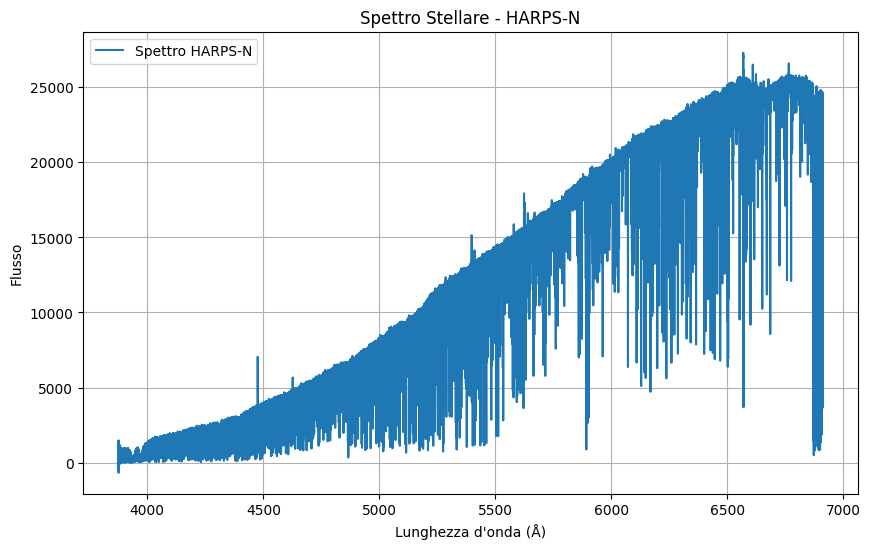

In [ ]:
os.chdir(path_to_ARES)
file_fits = "HARPN14.fits"
hdul = fits.open(file_fits)

# Stampa informazioni sul file FITS
hdul.info()

print(f"{len(hdul[0].data)} {type(hdul[0].data)}")

Y = hdul[0].data 
X = np.linspace(3875.321, 6911.574, len(Y))

plt.figure(figsize=(10, 6))
plt.plot(X, Y, label="Spettro HARPS-N")
plt.xlabel("Lunghezza d'onda (Å)")
plt.ylabel("Flusso")
plt.title("Spettro Stellare - HARPS-N")
plt.legend()
plt.grid()
plt.show()
